In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import numpy as np



In [2]:
predictions_path = "/Users/sagardhal/Desktop/Practice/personal-stock/results/predictions_20250908_092155.parquet"   # example


if predictions_path.endswith(".csv"):
    df = pd.read_csv(predictions_path)
elif predictions_path.endswith(".parquet"):
    df = pd.read_parquet(predictions_path)
else:
    raise ValueError("Unsupported file format for predictions")


print("Data loaded:", df.shape)
df.head()

new_df = df.copy()

Data loaded: (1372264, 642)


In [3]:
# List of ALL current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_declining_rates',
 'pred4_manual_fed_easing',
 'pred5_manual_vix_contrarian',
 'pred6_manual_stock_btc_momentum',
 'pred10_rf_thresh_21',
 'pred11_rf_thresh_50',
 'pred12_rf_thresh_65',
 'pred13_rf_thresh_80',
 'pred14_rf_thresh_90',
 'pred15_rf_auto_rate_1p',
 'pred15_rf_auto_rate_3p',
 'pred15_rf_auto_rate_5p',
 'pred30_top3_daily',
 'pred30_top5_daily',
 'pred30_top10_daily',
 'pred20_ens_ml50_and_momentum',
 'pred21_ens_auto1p_or_top3',
 'pred22_ens_manual2plus_and_auto3p']

In [4]:
new_df[(new_df.split=='test')].Date.nunique()

965

In [5]:
pred13_rf_thresh_80 = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred13_rf_thresh_80==1)].groupby('Date')['pred13_rf_thresh_80'].count())

array([[<Axes: title={'center': 'pred13_rf_thresh_80'}>]], dtype=object)

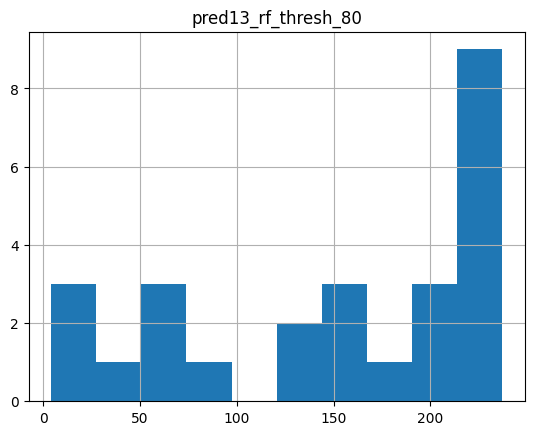

In [6]:
pred13_rf_thresh_80.hist()

In [7]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [8]:
to_predict = 'is_positive_growth_30d_future'


PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict= to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_declining_rates', 'pred4_manual_fed_easing', 'pred5_manual_vix_contrarian', 'pred6_manual_stock_btc_momentum', 'pred10_rf_thresh_21', 'pred11_rf_thresh_50', 'pred12_rf_thresh_65', 'pred13_rf_thresh_80', 'pred14_rf_thresh_90', 'pred15_rf_auto_rate_1p', 'pred15_rf_auto_rate_3p', 'pred15_rf_auto_rate_5p', 'pred30_top3_daily', 'pred30_top5_daily', 'pred30_top10_daily', 'pred20_ens_ml50_and_momentum', 'pred21_ens_auto1p_or_top3', 'pred22_ens_manual2plus_and_auto3p']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred10', 'is_correct_pred11', 'is_correct_pred12', 'is_correct_pred13', 'is_correct_pred14', 'is_correct_pred15', 'is_correct_pred30', 'is_correct_pred20', 'is_correct_pred21', 'is_correct_pred22']
Precision on TEST set for each predi

In [9]:
new_df.groupby('split').Date.agg(['min','max'])

,min,max
split,,
test,2021-10-28,2025-09-03
train,2000-01-03,2017-12-21
validation,2017-12-22,2021-10-27


In [10]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 30 * sim1_q75_investments_per_day # 30 days in a row with positive predictions

  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 5696 out of 237417 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    7474.923986
sim1_fees_pred0        -1139.200000
sim1_net_rev_pred0      6335.723986
dtype: float64
        Count Investments in 4 years (on TEST): 5696
        Gross Revenue: $7474
        Fees (0.2% for buy+sell): $1139
        Net Revenue: $6335
        Fees are 15 % from Gross Revenue
        Capital Required : $27000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $33335 (Vfinal)
        Average CAGR on TEST (4 years) : 1.054, or 5.4% 
        Average daily stats: 
            Average net revenue per investment: $1.11 
            Average investments per day: 7 
            Q75 investments per day: 9 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 130690 out of 237417 TEST records
    Financial Result: 
 sim1_gross_rev_pred1

In [15]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [16]:
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,5696,7474.923986,-1139.2,6335.723986,0.152403,1.112311,7.075776,27000.0,1.054111,1.234656
1,pred1_manual_prev_g1,130690,115721.035846,-26138.0,89583.035846,0.225871,0.685462,135.430052,528000.0,1.039957,1.169665
2,pred2_manual_prev_g1_and_snp,0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,pred3_manual_declining_rates,30129,165076.689632,-6025.8,159050.889632,0.036503,5.278997,249.000000,747000.0,1.049441,1.212920
4,pred4_manual_fed_easing,66370,-31110.953185,-13274.0,-44384.953185,NaN,-0.668750,243.113553,747000.0,0.984803,0.940582
5,pred5_manual_vix_contrarian,51955,176351.397854,-10391.0,165960.397854,0.058922,3.194310,247.404762,747000.0,1.051436,1.222169
6,pred6_manual_stock_btc_momentum,0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
7,pred10_rf_thresh_21,237417,347908.645743,-47483.4,300425.245743,0.136482,1.265391,246.027979,747000.0,1.088180,1.402176
8,pred11_rf_thresh_50,193671,580061.472192,-38734.2,541327.272192,0.066776,2.795087,237.341912,747000.0,1.145978,1.724668
9,pred12_rf_thresh_65,13684,161977.901776,-2736.8,159241.101776,0.016896,11.637029,195.485714,738000.0,1.050058,1.215774


In [17]:
import plotly.express as px

# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()

In [18]:
# detailed info from the bubble chart above on the winners
# top 1 result
df_sim1_results[df_sim1_results.prediction.isin(['pred21_ens_auto1p_or_top3'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
19,pred21_ens_auto1p_or_top3,2895,12756.946263,-579.0,12177.946263,0.045387,4.206544,3.0,9000.0,1.238541,2.353105


## . Advanced Simulation
* to_predict = 'is_positive_growth_30d_future'
* invest ~3% of capital each day (sell positions from 30 days ago), REINVEST PREVIOUS GAINS
* use predict_proba predictions
* select top1..3..x predictions > threshold (0.53)
* invest proportionally the prediction
* stop loss y%
* take profit z%
* Not included: portfolio optimization

In [19]:
new_df.columns.to_list()

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'adj_close',
 'Volume',
 'Ticker',
 'year',
 'month',
 'weekday',
 'wom',
 'month_wom',
 'growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_252d',
 'growth_365d',
 'growth_future_30d',
 'is_positive_growth_30d_future',
 'sma10',
 'sma20',
 'growing_moving_average',
 'volatility',
 'sharpe',
 'high_minus_low_relative',
 'ln_volume',
 'ticker_type',
 'adx',
 'adxr',
 'apo',
 'aroon_up',
 'aroon_down',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macd_signal',
 'macd_hist',
 'macd_ext',
 'macd_signal_ext',
 'macd_hist_ext',
 'macd_fix',
 'macd_signal_fix',
 'macd_hist_fix',
 'mfi',
 'minus_di',
 'plus_di',
 'plus_dm',
 'mom',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'stoch_slowk',
 'stoch_slowd',
 'stoch_fastk',
 'stoch_fastd',
 'stochrsi_fastk',
 'stochrsi_fastd',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'trange',
 'ht_dcperiod',
 'ht_dcphase',
 'ht_phasor_in

In [20]:
# https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe
# rank of prediction

new_df["rf_pred_rank"] = new_df.groupby("Date")["rf_prob_30d"].rank(method="first", ascending=False)



In [21]:
new_df = new_df.sort_values(by=['Ticker', 'Date'])
new_df.head()

,Date,Open,High,Low,Close,adj_close,Volume,Ticker,year,month,...,sim1_gross_rev_pred20,sim1_fees_pred20,sim1_net_rev_pred20,sim1_gross_rev_pred21,sim1_fees_pred21,sim1_net_rev_pred21,sim1_gross_rev_pred22,sim1_fees_pred22,sim1_net_rev_pred22,rf_pred_rank
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.840094,535796800.0,AAPL,2000,1,...,6.309323,-0.2,6.109323,6.309323,-0.2,6.109323,0.0,0.0,0.0,2.0
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.769266,512377600.0,AAPL,2000,1,...,11.341385,-0.2,11.141385,11.341385,-0.2,11.141385,0.0,0.0,0.0,3.0
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.780523,778321600.0,AAPL,2000,1,...,10.456827,-0.2,10.256827,10.456827,-0.2,10.256827,0.0,0.0,0.0,3.0
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.712978,767972800.0,AAPL,2000,1,...,17.105359,-0.2,16.905359,17.105359,-0.2,16.905359,0.0,0.0,0.0,1.0
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.746750,460734400.0,AAPL,2000,1,...,14.384404,-0.2,14.184404,14.384404,-0.2,14.184404,0.0,0.0,0.0,1.0


In [22]:
new_df['growth_future_30d'].describe().T

count    1.372264e+06
mean     1.019767e+00
std      1.287381e-01
min      2.264101e-04
25%      9.568989e-01
50%      1.018257e+00
75%      1.078546e+00
max      5.394737e+00
Name: growth_future_30d, dtype: float64

In [23]:
new_df['growth_future_30d'].quantile(0.95)

np.float64(1.2077565203831995)

In [24]:
# stop loss when -11%
new_df['growth_future_30d'].quantile(0.1)

np.float64(0.8886610734788174)

In [25]:
# check a sample on the test dataset
new_df[new_df.split=='test'][['Date','High','Low','Close','Ticker','ticker_type','growth_future_30d']].sample(10)

,Date,High,Low,Close,Ticker,ticker_type,growth_future_30d
132943,2022-07-26,39.570000,38.880001,38.959999,INTC,US,0.786704
509440,2024-05-01,237.080002,234.169998,234.960007,UNP,US,0.945352
874687,2023-01-31,759.710022,746.090027,759.210022,BLK,US,0.832102
447778,2023-10-26,31.370001,30.500000,31.160000,PFE,US,0.923620
297544,2023-08-10,695.320007,676.119995,677.809998,ASML,US,0.866172
1365082,2022-10-03,165.520004,161.350006,165.089996,WM,US,0.954570
1007455,2023-12-04,74.169998,71.730003,73.099998,ON,US,1.001642
922779,2022-03-01,253.270004,247.320007,252.419998,HCA,US,1.033555
303782,2022-10-05,1745.000000,1709.569946,1726.709961,BKNG,US,1.166253
102607,2025-08-04,196.080002,190.919998,195.750000,GOOG,US,1.202957


In [26]:
# Define a function to get the rolling max High and min Low for the next 30 trading days

# Sort the DataFrame: Sorting by Ticker and Date ensures that we are looking at each ticker's data in chronological order.
# Rolling window calculation: We use the rolling method with a window of 5 to calculate the maximum high and minimum low over the next 5 days.
# The shift method is used to align these values correctly with the current row.

def rolling_max_min(df, window=30):
    # high/low in 30 days
    df['Max_High_Next_30'] = df['High'].rolling(window=window, min_periods=1).max().shift(-window+1)
    df['Min_Low_Next_30'] = df['Low'].rolling(window=window, min_periods=1).min().shift(-window+1)

    # low in 1 day (for lower entry)
    df['Min_Low_Next_1'] = df['Low'].rolling(window=1, min_periods=1).min().shift(-1)
    return df

In [27]:
# Apply the function to each group of Ticker
# Important!: need to drop index from groupby operation (reset_index) - so that you can merge that afterwards
result = new_df[new_df.split=='test'][['Date','High','Low','Close','Ticker']].groupby('Ticker').apply(rolling_max_min).reset_index(drop=True)
result.head(30)

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/1575825617.py:3: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
0,2021-10-28,153.169998,149.720001,152.570007,AAPL,176.750000,146.410004,146.410004
1,2021-10-29,149.940002,146.410004,149.800003,AAPL,179.630005,146.410004,147.800003
2,2021-11-01,149.699997,147.800003,148.960007,AAPL,182.130005,147.479996,148.649994
3,2021-11-02,151.570007,148.649994,150.020004,AAPL,182.130005,147.479996,149.820007
4,2021-11-03,151.970001,149.820007,151.490005,AAPL,182.130005,147.479996,150.639999
5,2021-11-04,152.429993,150.639999,150.960007,AAPL,182.130005,147.479996,150.059998
6,2021-11-05,152.199997,150.059998,151.279999,AAPL,182.130005,147.479996,150.160004
7,2021-11-08,151.570007,150.160004,150.440002,AAPL,182.130005,147.479996,150.059998
8,2021-11-09,151.429993,150.059998,150.809998,AAPL,182.130005,147.479996,147.850006
9,2021-11-10,150.130005,147.850006,147.919998,AAPL,182.130005,147.479996,147.679993


In [28]:
result[result.Ticker=='AAPL'].tail(10)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
949,2025-08-20,230.470001,225.770004,226.009995,AAPL,NaN,NaN,223.779999
950,2025-08-21,226.520004,223.779999,224.899994,AAPL,NaN,NaN,225.410004
951,2025-08-22,229.089996,225.410004,227.759995,AAPL,NaN,NaN,226.229996
952,2025-08-25,229.300003,226.229996,227.160004,AAPL,NaN,NaN,224.690002
953,2025-08-26,229.490005,224.690002,229.309998,AAPL,NaN,NaN,228.259995
954,2025-08-27,230.899994,228.259995,230.490005,AAPL,NaN,NaN,229.339996
955,2025-08-28,233.410004,229.339996,232.559998,AAPL,NaN,NaN,231.369995
956,2025-08-29,233.380005,231.369995,232.139999,AAPL,NaN,NaN,226.970001
957,2025-09-02,230.850006,226.970001,229.720001,AAPL,NaN,NaN,234.360001
958,2025-09-03,238.850006,234.360001,238.470001,AAPL,NaN,NaN,NaN


In [29]:
# Calculate the ratios + safe divide
result['Ratio_MaxHighNext30_to_Close'] = np.where(result['Close'] == 0, np.nan, result['Max_High_Next_30']/result['Close'])
result['Ratio_MinLowNext30_to_Close'] =  np.where(result['Close'] == 0, np.nan,  result['Min_Low_Next_30']/result['Close'])

result['Ratio_MinLowNext1_to_Close'] =  np.where(result['Close'] == 0, np.nan,  result['Min_Low_Next_1']/result['Close'])

In [30]:
result[result.Ticker=='AAPL'].head(10)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
0,2021-10-28,153.169998,149.720001,152.570007,AAPL,176.750000,146.410004,146.410004,1.158485,0.959625,0.959625
1,2021-10-29,149.940002,146.410004,149.800003,AAPL,179.630005,146.410004,147.800003,1.199132,0.977370,0.986649
2,2021-11-01,149.699997,147.800003,148.960007,AAPL,182.130005,147.479996,148.649994,1.222677,0.990064,0.997919
3,2021-11-02,151.570007,148.649994,150.020004,AAPL,182.130005,147.479996,149.820007,1.214038,0.983069,0.998667
4,2021-11-03,151.970001,149.820007,151.490005,AAPL,182.130005,147.479996,150.639999,1.202258,0.973530,0.994389
5,2021-11-04,152.429993,150.639999,150.960007,AAPL,182.130005,147.479996,150.059998,1.206479,0.976947,0.994038
6,2021-11-05,152.199997,150.059998,151.279999,AAPL,182.130005,147.479996,150.160004,1.203927,0.974881,0.992597
7,2021-11-08,151.570007,150.160004,150.440002,AAPL,182.130005,147.479996,150.059998,1.210649,0.980324,0.997474
8,2021-11-09,151.429993,150.059998,150.809998,AAPL,182.130005,147.479996,147.850006,1.207679,0.977919,0.980373
9,2021-11-10,150.130005,147.850006,147.919998,AAPL,182.130005,147.479996,147.679993,1.231274,0.997025,0.998377


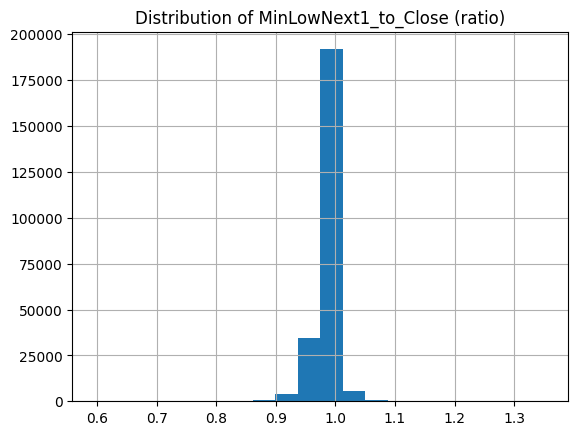

In [31]:
result.Ratio_MinLowNext1_to_Close.hist(bins=20)
plt.title(f'Distribution of MinLowNext1_to_Close (ratio)')
# Show the plot
plt.show()

In [32]:
result.Ratio_MinLowNext1_to_Close.describe().T

count    237144.000000
mean          0.987140
std           0.019359
min           0.595940
25%           0.980789
50%           0.990631
75%           0.997321
max           1.353308
Name: Ratio_MinLowNext1_to_Close, dtype: float64

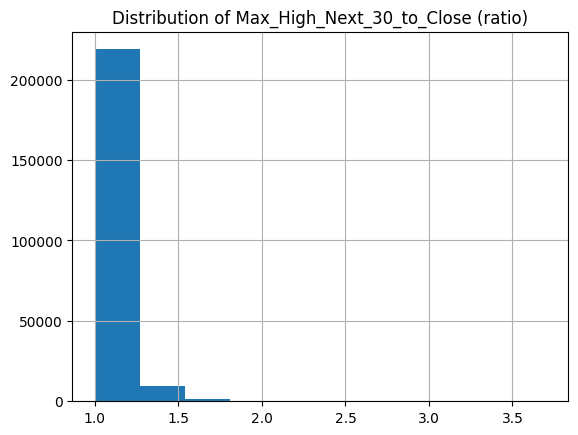

In [33]:
result.Ratio_MaxHighNext30_to_Close.hist()
plt.title(f'Distribution of Max_High_Next_30_to_Close (ratio)')
# Show the plot
plt.show()

In [34]:
result[result.Ratio_MaxHighNext30_to_Close>=1.3].sample(5)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
202139,2022-10-13,75.849998,67.809998,75.110001,TER,97.739998,67.809998,71.199997,1.301291,0.902809,0.947943
182262,2023-11-07,93.059998,90.000000,92.959999,RCL,124.230003,90.000000,93.139999,1.336381,0.968158,1.001936
153166,2022-08-09,12.680000,11.860000,12.100000,NCLH,15.800000,11.860000,12.600000,1.305785,0.980165,1.041322
76189,2025-05-23,63.930000,62.570000,63.689999,EL,89.860001,62.570000,64.540001,1.410897,0.982415,1.013346
104334,2025-04-25,136.460007,133.740005,135.759995,HWM,177.250000,133.740005,135.059998,1.305613,0.985121,0.994844


In [35]:
# ~1.8% cases TAKE PROFIT (30%)
len(result[result.Ratio_MaxHighNext30_to_Close>=1.3])/len(result)

0.035477661667024686

<Axes: >

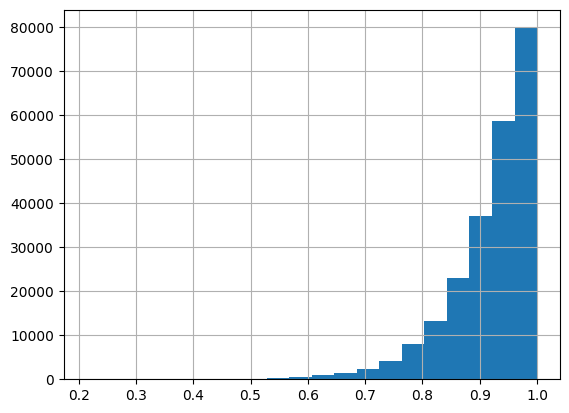

In [36]:
# High intra-day volatility, especially on earlier days after the IPO
result.Ratio_MinLowNext30_to_Close.hist(bins=20)

In [37]:
result.Ratio_MinLowNext30_to_Close.describe().T

count    230172.000000
mean          0.917708
std           0.074350
min           0.213045
25%           0.886190
50%           0.939388
75%           0.971852
max           1.000000
Name: Ratio_MinLowNext30_to_Close, dtype: float64

In [38]:
result[result.Ratio_MinLowNext30_to_Close<=0.8].sample(5)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
16428,2022-04-11,32.509998,31.735001,31.790001,ANET,33.212502,24.629999,31.740000,1.044747,0.774772,0.998427
235721,2022-09-26,164.380005,158.779999,159.759995,ZS,185.990005,117.410004,159.990005,1.164184,0.734915,1.001440
147056,2025-01-13,115.330002,111.550003,115.150002,MRVL,127.480003,91.730003,113.879997,1.107078,0.796613,0.988971
175243,2022-08-19,298.720001,294.350006,295.760010,PH,298.720001,235.690002,284.579987,1.010008,0.796896,0.962199
176982,2021-12-02,19.910000,19.059999,19.690001,PLTR,20.150000,15.350000,18.400000,1.023362,0.779584,0.934484


In [39]:
# Merge the results back with the original dataframe
new_df = new_df.merge(result[['Date', 'Ticker', 'Max_High_Next_30', 'Min_Low_Next_30','Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']], on=['Date', 'Ticker'])


new_df.sample(5)

,Date,Open,High,Low,Close,adj_close,Volume,Ticker,year,month,...,sim1_net_rev_pred21,sim1_gross_rev_pred22,sim1_fees_pred22,sim1_net_rev_pred22,rf_pred_rank,Max_High_Next_30,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
11228,2024-07-05,98.779999,100.339996,97.110001,98.349998,96.342033,2229800.0,ALB,2024,7,...,0.0,-0.0,0.0,0.0,57.0,101.650002,71.970001,1.033554,0.731774,1.007728
156336,2023-10-09,378.049988,387.170013,377.760010,385.950012,385.950012,3299800.0,NFLX,2023,10,...,0.0,0.0,0.0,0.0,191.0,467.649994,344.730011,1.211685,0.893199,0.964503
66727,2022-01-31,56.220001,56.810001,55.950001,56.810001,52.264488,3319000.0,DELL,2022,1,...,0.0,-0.0,0.0,0.0,42.0,61.540001,48.980000,1.083260,0.862172,0.994367
25188,2024-08-22,246.770004,248.919998,245.759995,247.759995,245.100098,1981300.0,AXP,2024,8,...,0.0,0.0,0.0,0.0,38.0,272.679993,240.589996,1.100581,0.971061,1.000969
45916,2023-04-27,249.440002,251.100006,247.789993,250.330002,240.551880,1138700.0,CI,2023,4,...,0.0,0.0,0.0,0.0,15.0,269.880005,240.500000,1.078097,0.960732,0.995566


### Generate fin.result for one date

In [40]:
from dataclasses import dataclass

@dataclass
class SimulationParams:
    initial_capital: float
    threshold: float
    fees: float
    top_k: int
    portfolio_optimization: bool
    stop_loss: float
    take_profit: float
    lower_entry: float

In [41]:
# Example of initializing with some values
sim_params = SimulationParams(
    initial_capital=10000,        # initial capital = $10k
    threshold=0.53,               # select all binary predictions with probability>=0.55
    fees=0.002,                   # trading fees = 0.2% (buy+sell)
    top_k=10,                     # select top_k predictions
    portfolio_optimization=False, # no portfolio optimizaiton
    stop_loss=0.8,                # automatic sell (with loss) if price (any of next 30 days) is lower than -20% from Close
    take_profit=1.3,              # automatic sell (with profit) if price (any of next 30 days) is higher than +30% from Close
    lower_entry= 0.995                # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

print(sim_params)

SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=10, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.995)


In [42]:
# sorted array of dates for Simulation
DATES = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
print(f' Min date {DATES.min()}, max date {DATES.max()}')

 Min date 2021-10-28 00:00:00, max date 2025-09-03 00:00:00


In [43]:
date = DATES[0]
date

Timestamp('2021-10-28 00:00:00')

In [44]:
# 1. get TOP_K predictions from pred10_rf_best_rule_50, that are higher than THE THRESHOLD
if sim_params.top_k is None:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.rf_prob_30d > sim_params.threshold)]
else:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.rf_prob_30d > sim_params.threshold)&(new_df.rf_pred_rank<=sim_params.top_k)]


one_day_predictions_df[['Date','Ticker',to_predict,'growth_future_30d','rf_prob_30d','rf_pred_rank',]]

,Date,Ticker,is_positive_growth_30d_future,growth_future_30d,rf_prob_30d,rf_pred_rank
32165,2021-10-28,BMY,0,0.986522,0.532906,10.0
36966,2021-10-28,CAH,1,1.016136,0.533081,7.0
47459,2021-10-28,CMCSA,0,0.933526,0.533267,6.0
69540,2021-10-28,DIS,0,0.899988,0.533675,5.0
90992,2021-10-28,GILD,1,1.043214,0.534367,2.0
142416,2021-10-28,MNST,1,1.054770,0.537549,1.0
166403,2021-10-28,OTIS,1,1.077077,0.533078,8.0
177917,2021-10-28,PM,0,0.938210,0.534254,3.0
223020,2021-10-28,VRTX,1,1.143187,0.533020,9.0
228774,2021-10-28,WELL,0,0.999758,0.533928,4.0


In [45]:
# 2. Get non-normalized weights: probability-threshold + 0.01
one_day_predictions_df['weight'] = one_day_predictions_df.rf_prob_30d - sim_params.threshold +0.01

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/4279940281.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
one_day_predictions_df[['Date','Ticker','Close', to_predict,'growth_future_30d','rf_prob_30d','rf_pred_rank','weight']]

,Date,Ticker,Close,is_positive_growth_30d_future,growth_future_30d,rf_prob_30d,rf_pred_rank,weight
32165,2021-10-28,BMY,57.130001,0,0.986522,0.532906,10.0,0.012906
36966,2021-10-28,CAH,47.720001,1,1.016136,0.533081,7.0,0.013081
47459,2021-10-28,CMCSA,51.900002,0,0.933526,0.533267,6.0,0.013267
69540,2021-10-28,DIS,169.679993,0,0.899988,0.533675,5.0,0.013675
90992,2021-10-28,GILD,67.339996,1,1.043214,0.534367,2.0,0.014367
142416,2021-10-28,MNST,42.450001,1,1.054770,0.537549,1.0,0.017549
166403,2021-10-28,OTIS,79.919998,1,1.077077,0.533078,8.0,0.013078
177917,2021-10-28,PM,95.970001,0,0.938210,0.534254,3.0,0.014254
223020,2021-10-28,VRTX,182.000000,1,1.143187,0.533020,9.0,0.013020
228774,2021-10-28,WELL,82.730003,0,0.999758,0.533928,4.0,0.013928


In [47]:
# 3. Get normalized weights
one_day_predictions_df['weight_norm'] = one_day_predictions_df['weight']/one_day_predictions_df['weight'].sum()

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/652482825.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
one_day_predictions_df[['Date','Ticker','Close', to_predict,'growth_future_30d','rf_prob_30d','rf_pred_rank','weight','weight_norm']]

,Date,Ticker,Close,is_positive_growth_30d_future,growth_future_30d,rf_prob_30d,rf_pred_rank,weight,weight_norm
32165,2021-10-28,BMY,57.130001,0,0.986522,0.532906,10.0,0.012906,0.092767
36966,2021-10-28,CAH,47.720001,1,1.016136,0.533081,7.0,0.013081,0.094025
47459,2021-10-28,CMCSA,51.900002,0,0.933526,0.533267,6.0,0.013267,0.095360
69540,2021-10-28,DIS,169.679993,0,0.899988,0.533675,5.0,0.013675,0.098291
90992,2021-10-28,GILD,67.339996,1,1.043214,0.534367,2.0,0.014367,0.103270
142416,2021-10-28,MNST,42.450001,1,1.054770,0.537549,1.0,0.017549,0.126135
166403,2021-10-28,OTIS,79.919998,1,1.077077,0.533078,8.0,0.013078,0.094004
177917,2021-10-28,PM,95.970001,0,0.938210,0.534254,3.0,0.014254,0.102452
223020,2021-10-28,VRTX,182.000000,1,1.143187,0.533020,9.0,0.013020,0.093585
228774,2021-10-28,WELL,82.730003,0,0.999758,0.533928,4.0,0.013928,0.100111


In [49]:
# 4. Capital: either 1/30 of initial (assuming you trade every day), or everything that you can sell from 30 days ago
one_day_predictions_df['investment'] = one_day_predictions_df['weight_norm'] * sim_params.initial_capital /30

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/3531095870.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
one_day_predictions_df[['Date','Ticker','Close', to_predict,'growth_future_30d','rf_prob_30d','rf_pred_rank','weight','weight_norm','investment']]

,Date,Ticker,Close,is_positive_growth_30d_future,growth_future_30d,rf_prob_30d,rf_pred_rank,weight,weight_norm,investment
32165,2021-10-28,BMY,57.130001,0,0.986522,0.532906,10.0,0.012906,0.092767,30.922436
36966,2021-10-28,CAH,47.720001,1,1.016136,0.533081,7.0,0.013081,0.094025,31.341613
47459,2021-10-28,CMCSA,51.900002,0,0.933526,0.533267,6.0,0.013267,0.095360,31.786754
69540,2021-10-28,DIS,169.679993,0,0.899988,0.533675,5.0,0.013675,0.098291,32.763501
90992,2021-10-28,GILD,67.339996,1,1.043214,0.534367,2.0,0.014367,0.103270,34.423423
142416,2021-10-28,MNST,42.450001,1,1.054770,0.537549,1.0,0.017549,0.126135,42.045128
166403,2021-10-28,OTIS,79.919998,1,1.077077,0.533078,8.0,0.013078,0.094004,31.334602
177917,2021-10-28,PM,95.970001,0,0.938210,0.534254,3.0,0.014254,0.102452,34.150647
223020,2021-10-28,VRTX,182.000000,1,1.143187,0.533020,9.0,0.013020,0.093585,31.195042
228774,2021-10-28,WELL,82.730003,0,0.999758,0.533928,4.0,0.013928,0.100111,33.370187


In [51]:
# 5. Lower Entry: the trade is executed only is Low price for next day is lower than bet
one_day_predictions_df['lower_entry'] = (one_day_predictions_df['Ratio_MinLowNext1_to_Close']<=sim_params.lower_entry).astype(int)

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/3812536821.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
one_day_predictions_df.tail(10)

,Date,Open,High,Low,Close,adj_close,Volume,Ticker,year,month,...,rf_pred_rank,Max_High_Next_30,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry
32165,2021-10-28,56.529999,57.750000,56.349998,57.130001,49.182384,16380800.0,BMY,2021,10,...,10.0,60.200001,53.220001,1.053737,0.931560,1.000175,0.012906,0.092767,30.922436,0
36966,2021-10-28,47.580002,48.029999,47.150002,47.720001,43.655903,4778600.0,CAH,2021,10,...,7.0,51.480000,45.849998,1.078793,0.960813,0.994971,0.013081,0.094025,31.341613,1
47459,2021-10-28,50.400002,52.740002,49.799999,51.900002,46.436321,21159400.0,CMCSA,2021,10,...,6.0,54.590000,47.590000,1.051830,0.916956,0.984971,0.013267,0.095360,31.786754,1
69540,2021-10-28,169.479996,170.350006,168.600006,169.679993,166.897690,7884500.0,DIS,2021,10,...,5.0,179.250000,142.039993,1.056400,0.837105,0.990983,0.013675,0.098291,32.763501,1
90992,2021-10-28,66.699997,67.660004,66.669998,67.339996,58.148861,5884800.0,GILD,2021,10,...,2.0,71.320000,64.059998,1.059103,0.951292,0.951292,0.014367,0.103270,34.423423,1
142416,2021-10-28,42.549999,42.820000,42.165001,42.450001,42.450001,3151600.0,MNST,2021,10,...,1.0,46.904999,40.459999,1.104947,0.953121,0.998233,0.017549,0.126135,42.045128,0
166403,2021-10-28,79.599998,80.160004,78.599998,79.919998,75.134842,2435300.0,OTIS,2021,10,...,8.0,87.830002,78.599998,1.098974,0.983483,0.995245,0.013078,0.094004,31.334602,0
177917,2021-10-28,94.449997,96.019997,94.449997,95.970001,79.695908,4754500.0,PM,2021,10,...,3.0,96.070000,85.639999,1.001042,0.892362,0.982703,0.014254,0.102452,34.150647,1
223020,2021-10-28,181.190002,183.830002,181.009995,182.000000,182.000000,1356700.0,VRTX,2021,10,...,9.0,209.000000,179.960007,1.148352,0.988791,0.992692,0.013020,0.093585,31.195042,1
228774,2021-10-28,82.300003,82.830002,81.750000,82.730003,74.472404,1165700.0,WELL,2021,10,...,4.0,87.639999,79.209999,1.059350,0.957452,0.961199,0.013928,0.100111,33.370187,1


In [53]:
one_day_predictions_df['stop_loss'] = (one_day_predictions_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/1852971020.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
one_day_predictions_df['take_profit'] = (one_day_predictions_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/2668271904.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
one_day_predictions_df.tail(10)

,Date,Open,High,Low,Close,adj_close,Volume,Ticker,year,month,...,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit
32165,2021-10-28,56.529999,57.750000,56.349998,57.130001,49.182384,16380800.0,BMY,2021,10,...,53.220001,1.053737,0.931560,1.000175,0.012906,0.092767,30.922436,0,0,0
36966,2021-10-28,47.580002,48.029999,47.150002,47.720001,43.655903,4778600.0,CAH,2021,10,...,45.849998,1.078793,0.960813,0.994971,0.013081,0.094025,31.341613,1,0,0
47459,2021-10-28,50.400002,52.740002,49.799999,51.900002,46.436321,21159400.0,CMCSA,2021,10,...,47.590000,1.051830,0.916956,0.984971,0.013267,0.095360,31.786754,1,0,0
69540,2021-10-28,169.479996,170.350006,168.600006,169.679993,166.897690,7884500.0,DIS,2021,10,...,142.039993,1.056400,0.837105,0.990983,0.013675,0.098291,32.763501,1,0,0
90992,2021-10-28,66.699997,67.660004,66.669998,67.339996,58.148861,5884800.0,GILD,2021,10,...,64.059998,1.059103,0.951292,0.951292,0.014367,0.103270,34.423423,1,0,0
142416,2021-10-28,42.549999,42.820000,42.165001,42.450001,42.450001,3151600.0,MNST,2021,10,...,40.459999,1.104947,0.953121,0.998233,0.017549,0.126135,42.045128,0,0,0
166403,2021-10-28,79.599998,80.160004,78.599998,79.919998,75.134842,2435300.0,OTIS,2021,10,...,78.599998,1.098974,0.983483,0.995245,0.013078,0.094004,31.334602,0,0,0
177917,2021-10-28,94.449997,96.019997,94.449997,95.970001,79.695908,4754500.0,PM,2021,10,...,85.639999,1.001042,0.892362,0.982703,0.014254,0.102452,34.150647,1,0,0
223020,2021-10-28,181.190002,183.830002,181.009995,182.000000,182.000000,1356700.0,VRTX,2021,10,...,179.960007,1.148352,0.988791,0.992692,0.013020,0.093585,31.195042,1,0,0
228774,2021-10-28,82.300003,82.830002,81.750000,82.730003,74.472404,1165700.0,WELL,2021,10,...,79.209999,1.059350,0.957452,0.961199,0.013928,0.100111,33.370187,1,0,0


In [56]:
# future_gross_return, depending on lower_entry, take_profit, stop_loss

import random

def get_future_gross_return(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade, investment is untouched, no fees
    return row['investment']

  # buy trade is filled for ALL next cases:
  if row['take_profit']==1 and row['stop_loss']==1:
    if random.random()>0.5: #assume take_profit event was first
      return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))
    else: #assume stop_loss event was first
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  if row['take_profit']==1: # take some good profit, pay fees
    return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))

  if row['stop_loss']==1: # fix the loss, pay fees
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  # no stop_loss and no take_profit
  if pd.isna(row['growth_future_30d']):
    return row['investment'] # no information on growth in 30 days --> return the same investment in 5 days
  else:
    return row['investment']*(row['growth_future_30d']+(1-sim_params.lower_entry))

In [57]:
# fees, depending on lower_entry, take_profit, stop_loss

def get_fees(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade ==> no fees
    return 0

  # pay fees in all other cases
  return -row['investment']*sim_params.fees


In [58]:
# 8. calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
one_day_predictions_df['future_gross_return'] = one_day_predictions_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
one_day_predictions_df['fees'] =  one_day_predictions_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
one_day_predictions_df['future_net_return'] = one_day_predictions_df['future_gross_return'] + one_day_predictions_df['fees']

# OLD code when no stop_loss, take_profit, and if order executed
# one_day_predictions_df['investment'] * one_day_predictions_df['growth_future_5d']
# one_day_predictions_df['fees'] =   - one_day_predictions_df['investment'] * sim_params.fees


/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/3285038461.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/3285038461.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/3285038461.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [59]:
one_day_predictions_df

,Date,Open,High,Low,Close,adj_close,Volume,Ticker,year,month,...,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
32165,2021-10-28,56.529999,57.750000,56.349998,57.130001,49.182384,16380800.0,BMY,2021,10,...,1.000175,0.012906,0.092767,30.922436,0,0,0,30.922436,0.000000,30.922436
36966,2021-10-28,47.580002,48.029999,47.150002,47.720001,43.655903,4778600.0,CAH,2021,10,...,0.994971,0.013081,0.094025,31.341613,1,0,0,32.004043,-0.062683,31.941360
47459,2021-10-28,50.400002,52.740002,49.799999,51.900002,46.436321,21159400.0,CMCSA,2021,10,...,0.984971,0.013267,0.095360,31.786754,1,0,0,29.832695,-0.063574,29.769122
69540,2021-10-28,169.479996,170.350006,168.600006,169.679993,166.897690,7884500.0,DIS,2021,10,...,0.990983,0.013675,0.098291,32.763501,1,0,0,29.650584,-0.065527,29.585057
90992,2021-10-28,66.699997,67.660004,66.669998,67.339996,58.148861,5884800.0,GILD,2021,10,...,0.951292,0.014367,0.103270,34.423423,1,0,0,36.083101,-0.068847,36.014254
142416,2021-10-28,42.549999,42.820000,42.165001,42.450001,42.450001,3151600.0,MNST,2021,10,...,0.998233,0.017549,0.126135,42.045128,0,0,0,42.045128,0.000000,42.045128
166403,2021-10-28,79.599998,80.160004,78.599998,79.919998,75.134842,2435300.0,OTIS,2021,10,...,0.995245,0.013078,0.094004,31.334602,0,0,0,31.334602,0.000000,31.334602
177917,2021-10-28,94.449997,96.019997,94.449997,95.970001,79.695908,4754500.0,PM,2021,10,...,0.982703,0.014254,0.102452,34.150647,1,0,0,32.211227,-0.068301,32.142925
223020,2021-10-28,181.190002,183.830002,181.009995,182.000000,182.000000,1356700.0,VRTX,2021,10,...,0.992692,0.013020,0.093585,31.195042,1,0,0,35.817736,-0.062390,35.755346
228774,2021-10-28,82.300003,82.830002,81.750000,82.730003,74.472404,1165700.0,WELL,2021,10,...,0.961199,0.013928,0.100111,33.370187,1,0,0,33.528969,-0.066740,33.462229


## Wrap up one day simulation into a function

In [60]:
# Simulation Parameters
sim_params = SimulationParams(
    initial_capital=10000,                 # initial capital = $10k
    threshold=0.53,                        # select all binary predictions with probability>=0.55
    fees=0.002,                            # trading fees = 0.2% (buy+sell)
    top_k=10,                              # select top_k predictions
    portfolio_optimization=False,          # no portfolio optimizaiton
    stop_loss=0.8,                         # automatic sell (with loss) if price (any of next 30 trading days) is lower than -20% from Close
    take_profit=1.3,                       # automatic sell (with profit) if price (any of next 30 trading days) is higher than +30% from Close
    lower_entry= 0.995                     # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

In [61]:
def one_date_simulation(date:str, invest_sum:float, df:pd.DataFrame, sim_params:SimulationParams, predictor:str='proba_pred10'):

  #rank_column = predictor.split('_')[1]+'_rank' # e.g. 'proba_pred10' --> 'pred10_rank'
  rank_column = predictor.split('_')[0] +'_pred_rank'

  # 1. get TOP_K (or ALL) predictions from the predictor (pred14_rf_best_rule_53 by default), that are higher than THE THRESHOLD
  if sim_params.top_k is None:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)]
  else:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)&(df[rank_column]<=sim_params.top_k)]

  FIELDS = ['Close', 'Ticker', 'Date', predictor, rank_column, 'growth_future_30d', 'Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']
  result_df = one_day_predictions_df[FIELDS].copy()

  # 2. Get non-normalized weights: probability-threshold + 0.01
  result_df['weight'] = result_df[predictor] - sim_params.threshold +0.01

  # 3. Get normalized weights
  result_df['weight_norm'] = result_df['weight']/result_df['weight'].sum()

  # 4. Make bets to allocate 'invest_sum' across all suitable predictions
  result_df['investment'] = result_df['weight_norm'] * invest_sum

  # 5. Lower Entry: the trade is executed only is Low price for next day is lower than the bet (Adj_Close_today * sim_params.lower_entry)
    # [ONLY TRADES with lower_entry==1 are filled by the exchange]
  result_df['lower_entry'] = (result_df['Ratio_MinLowNext1_to_Close'] <= sim_params.lower_entry).astype(int)

  # 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
  result_df['stop_loss'] = (result_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)

  # 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
  result_df['take_profit'] = (result_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

  # 8. Calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
  result_df['future_gross_return'] = result_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
  result_df['fees'] =  result_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
  result_df['future_net_return'] = result_df['future_gross_return'] + result_df['fees']

  return result_df

In [62]:
predictor = 'rf_prob_30d'
rank_column = predictor.split('_')[0] +'_pred_rank'
print(rank_column)

rf_pred_rank


In [63]:
r = one_date_simulation(date='2021-10-28', invest_sum=sim_params.initial_capital/30, df=new_df, sim_params=sim_params, predictor=predictor)

In [64]:
r

,Close,Ticker,Date,rf_prob_30d,rf_pred_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
32165,57.130001,BMY,2021-10-28,0.532906,10.0,0.986522,1.053737,0.931560,1.000175,0.012906,0.092767,30.922436,0,0,0,30.922436,0.000000,30.922436
36966,47.720001,CAH,2021-10-28,0.533081,7.0,1.016136,1.078793,0.960813,0.994971,0.013081,0.094025,31.341613,1,0,0,32.004043,-0.062683,31.941360
47459,51.900002,CMCSA,2021-10-28,0.533267,6.0,0.933526,1.051830,0.916956,0.984971,0.013267,0.095360,31.786754,1,0,0,29.832695,-0.063574,29.769122
69540,169.679993,DIS,2021-10-28,0.533675,5.0,0.899988,1.056400,0.837105,0.990983,0.013675,0.098291,32.763501,1,0,0,29.650584,-0.065527,29.585057
90992,67.339996,GILD,2021-10-28,0.534367,2.0,1.043214,1.059103,0.951292,0.951292,0.014367,0.103270,34.423423,1,0,0,36.083101,-0.068847,36.014254
142416,42.450001,MNST,2021-10-28,0.537549,1.0,1.054770,1.104947,0.953121,0.998233,0.017549,0.126135,42.045128,0,0,0,42.045128,0.000000,42.045128
166403,79.919998,OTIS,2021-10-28,0.533078,8.0,1.077077,1.098974,0.983483,0.995245,0.013078,0.094004,31.334602,0,0,0,31.334602,0.000000,31.334602
177917,95.970001,PM,2021-10-28,0.534254,3.0,0.938210,1.001042,0.892362,0.982703,0.014254,0.102452,34.150647,1,0,0,32.211227,-0.068301,32.142925
223020,182.000000,VRTX,2021-10-28,0.533020,9.0,1.143187,1.148352,0.988791,0.992692,0.013020,0.093585,31.195042,1,0,0,35.817736,-0.062390,35.755346
228774,82.730003,WELL,2021-10-28,0.533928,4.0,0.999758,1.059350,0.957452,0.961199,0.013928,0.100111,33.370187,1,0,0,33.528969,-0.066740,33.462229


In [65]:
# initial investment
r.investment.sum()

np.float64(333.33333333333326)

In [66]:
# result in 30 days (returns+fees)
r.future_net_return.sum()

np.float64(332.97245838848517)

# Generate fin result for ALL days

In [67]:
all_dates = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
all_dates

<DatetimeArray>
['2021-10-28 00:00:00', '2021-10-29 00:00:00', '2021-11-01 00:00:00',
 '2021-11-02 00:00:00', '2021-11-03 00:00:00', '2021-11-04 00:00:00',
 '2021-11-05 00:00:00', '2021-11-08 00:00:00', '2021-11-09 00:00:00',
 '2021-11-10 00:00:00',
 ...
 '2025-08-20 00:00:00', '2025-08-21 00:00:00', '2025-08-22 00:00:00',
 '2025-08-25 00:00:00', '2025-08-26 00:00:00', '2025-08-27 00:00:00',
 '2025-08-28 00:00:00', '2025-08-29 00:00:00', '2025-09-02 00:00:00',
 '2025-09-03 00:00:00']
Length: 965, dtype: datetime64[ns]

In [68]:
# simulate for all dates but last 5
all_dates[0:-5]

<DatetimeArray>
['2021-10-28 00:00:00', '2021-10-29 00:00:00', '2021-11-01 00:00:00',
 '2021-11-02 00:00:00', '2021-11-03 00:00:00', '2021-11-04 00:00:00',
 '2021-11-05 00:00:00', '2021-11-08 00:00:00', '2021-11-09 00:00:00',
 '2021-11-10 00:00:00',
 ...
 '2025-08-13 00:00:00', '2025-08-14 00:00:00', '2025-08-15 00:00:00',
 '2025-08-18 00:00:00', '2025-08-19 00:00:00', '2025-08-20 00:00:00',
 '2025-08-21 00:00:00', '2025-08-22 00:00:00', '2025-08-25 00:00:00',
 '2025-08-26 00:00:00']
Length: 960, dtype: datetime64[ns]

In [69]:
# these last days we only "sell" the positions
all_dates[-5:]

<DatetimeArray>
['2025-08-27 00:00:00', '2025-08-28 00:00:00', '2025-08-29 00:00:00',
 '2025-09-02 00:00:00', '2025-09-03 00:00:00']
Length: 5, dtype: datetime64[ns]

In [70]:
capital= 5 * [sim_params.initial_capital/5]
capital[-5]

2000.0

In [71]:
def simulate(df:pd.DataFrame, sim_params:SimulationParams):

  simulation_df = None

  # all dates for simulation
  all_dates = df[df.split=='test'].sort_values(by='Date').Date.unique()

  # arrays of dates and capital available (capital for the first 5 days)
  dates = []
  capital= 30 * [sim_params.initial_capital/30]  # first 30 periods trade with 1/30 of the initial_capital. e.g. [333,...,333] = 10k in total

  for current_date in all_dates[0:-30]:  #growth_future_30d is not defined for the last 30 days : ALL, but last 30 dates

    current_invest_sum = capital[-30]    # take the value or everything that you can sell from 30 days ago

    one_day_simulation_results = one_date_simulation(date = current_date,  # one day simulation result
                                    invest_sum = current_invest_sum,
                                    df = df,
                                    sim_params=sim_params,
                                    predictor=predictor)

    # add capital available in 30 days
    if len(one_day_simulation_results)==0:  #no predictions -> no trades
      capital.append(current_invest_sum)
    else:
      capital.append(one_day_simulation_results.future_net_return.sum())
    dates.append(current_date)

    if simulation_df is None:
      simulation_df = one_day_simulation_results
    else:
      simulation_df = pd.concat([simulation_df, one_day_simulation_results], ignore_index=True)

  # add last 5 days to make the count of data points equal for dates/capital arrays
  dates.extend(all_dates[-30:])
  capital_df = pd.DataFrame({'capital':capital}, index=pd.to_datetime(dates))

  # results:
  print(f'============================================================================================')
  print(f'SIMULATION STARTED')
  print(f'Simulations params: {sim_params}')
  print(f' Count bids {len(simulation_df)} in total, avg.bids per day {len(simulation_df)/simulation_df.Date.nunique()},  filled bids {len(simulation_df[simulation_df.lower_entry==1])}, fill bids percent = {len(simulation_df[simulation_df.lower_entry==1])/len(simulation_df)}')
  stop_loss_filter = (simulation_df.lower_entry==1)&(simulation_df.stop_loss==1)
  print(f'  Stop loss events: count = {len(simulation_df[stop_loss_filter])}, net loss = {simulation_df[stop_loss_filter].future_net_return.sum()-simulation_df[stop_loss_filter].investment.sum()} ')
  take_profit_filter = (simulation_df.lower_entry==1)&(simulation_df.take_profit==1)
  print(f'  Take profit events: count = {len(simulation_df[take_profit_filter])}, net profit = {simulation_df[take_profit_filter].future_net_return.sum()-simulation_df[take_profit_filter].investment.sum()} ')
  print(f'  Start capital = {sim_params.initial_capital}, Resulting capital: {capital_df[-30:].capital.sum()} ')
  print(f'  CAGR in 4 years: {np.round((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4),3)} or {np.round(((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4)-1)*100.0,2)} % of avg. growth per year')
  print(f'============================================================================================')
  return simulation_df,capital_df

In [72]:
# One initial simulation
sim_params = SimulationParams(
    initial_capital = 10000,        # initial capital = $10k
    threshold = 0.55,               # select all binary predictions with probability>=0.55
    fees = 0.002,                   # trading fees = 0.2% (buy+sell)
    top_k = 5,                      # select top_k=5 predictions
    portfolio_optimization = False, # no portfolio optimization
    stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -20% from Adj.Close
    take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +30% from Adj.Close
    lower_entry = 0.99               # buy next day with the price = [Close] * 0.99 (try to buy cheaper)
)

res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
 Count bids 2886 in total, avg.bids per day 4.916524701873935,  filled bids 1368, fill bids percent = 0.47401247401247404
  Stop loss events: count = 101, net loss = -2040.2784650252306 
  Take profit events: count = 110, net profit = 2924.785286649645 
  Start capital = 10000, Resulting capital: 15698.271798881451 
  CAGR in 4 years: 1.119 or 11.93 % of avg. growth per year


#  Find optimal parameters of simulation

In [73]:
# BEST PREVIOUS CAGR is 7.8%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
# iterate over lower_entry
for lower_entry in [0.97,0.98,0.99,1,1.01,1.02,1.03]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.97)
 Count bids 2886 in total, avg.bids per day 4.916524701873935,  filled bids 337, fill bids percent = 0.11677061677061677
  Stop loss events: count = 44, net loss = -580.2861923809596 
  Take profit events: count = 49, net profit = 1158.5070974554928 
  Start capital = 10000, Resulting capital: 11865.319592184042 
  CAGR in 4 years: 1.044 or 4.37 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.98)
 Count bids 2886 in total, avg.bids per day 4.916524701873935,  filled bids 647, fill bids percent = 0.2241857241857242
  Stop loss events: count = 64, net loss = -1064.4478996230137 
  Take profit events: count = 75, net profit = 180

In [74]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99 ==> lower_entry=1.0)

# iterate over take profit   ==> new best take_profit=1.5
for take_profit in [1.2,1.25,1.3,1.35,1.4,1.45,1.5]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 30 days) is lower than -5% from Adj.Close
      take_profit = take_profit,        # automatic sell (with profit) if price (any of next 30 days) is higher than +20% from Adj.Close
      lower_entry = 1                # buy next day with the price = [Close] * lower_entry (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.2, lower_entry=1)
 Count bids 2886 in total, avg.bids per day 4.916524701873935,  filled bids 2402, fill bids percent = 0.8322938322938322
  Stop loss events: count = 129, net loss = -2917.299237180174 
  Take profit events: count = 348, net profit = 6273.7153897897915 
  Start capital = 10000, Resulting capital: 16642.608656225042 
  CAGR in 4 years: 1.136 or 13.58 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.25, lower_entry=1)
 Count bids 2886 in total, avg.bids per day 4.916524701873935,  filled bids 2402, fill bids percent = 0.8322938322938322
  Stop loss events: count = 129, net loss = -3060.3537162666944 
  Take profit events: count = 204, net profit = 47

In [75]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=1.0)
# BEST PREVIOUS is CAGR 11.91%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 => take_profit=1.5, lower_entry=1.0)

# iterate over stop_loss
for stop_loss in [0.55,0.6,0.65,0.7,0.75,0.8]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = stop_loss,                # automatic sell (with loss) if price (any of next 30 days) is lower than -"stop_loss"% from Close
      take_profit = 1.5,              # automatic sell (with profit) if price (any of next 30 days) is higher than +50% from Close
      lower_entry = 1                # buy next day with the price = [Close] * 1 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.55, take_profit=1.5, lower_entry=1)
 Count bids 2886 in total, avg.bids per day 4.916524701873935,  filled bids 2402, fill bids percent = 0.8322938322938322
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 36, net profit = 1818.3494774021428 
  Start capital = 10000, Resulting capital: 19469.797100971417 
  CAGR in 4 years: 1.181 or 18.12 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 2886 in total, avg.bids per day 4.916524701873935,  filled bids 2402, fill bids percent = 0.8322938322938322
  Stop loss events: count = 2, net loss = -129.72357279583233 
  Take profit events: count = 36, net profit = 1818.3494774021428 
  S

In [76]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=1.0)
# BEST PREVIOUS is CAGR 11.91%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 => take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.19%  (top_k=5, portfolio_optimization=False, stop_loss=0.8 => stop_loss=0.6, take_profit=1.5, lower_entry=1.0)


# iterate over lower_entry ++ take profit of 2.5%
  # best lower_entry ==0.98
for threshold in [0.51,0.52,0.53,0.54,0.55,0.56,0.57]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = threshold,               # select all binary predictions with probability>=threshold (iter param)
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.6,                # automatic sell (with loss) if price (any of next 30 days) is lower than -40% from Close
      take_profit = 1.5,              # automatic sell (with profit) if price (any of next 30 days) is higher than +50% from Adj.Close
      lower_entry = 1                # buy next day with the price = [Close] * lower_entry (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.51, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 3844 in total, avg.bids per day 4.972833117723156,  filled bids 3221, fill bids percent = 0.8379292403746098
  Stop loss events: count = 3, net loss = -271.72337605920393 
  Take profit events: count = 50, net profit = 2713.3994101945036 
  Start capital = 10000, Resulting capital: 23109.846820632694 
  CAGR in 4 years: 1.233 or 23.3 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.52, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 3722 in total, avg.bids per day 4.962666666666666,  filled bids 3116, fill bids percent = 0.8371843095110156
  Stop loss events: count = 3, net loss = -234.77661431319615 
  Take profit events: count = 48, net profit = 2534.1146

In [77]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=1.0)
# BEST PREVIOUS is CAGR 11.91%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 => take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.19%  (top_k=5, portfolio_optimization=False, stop_loss=0.8 => stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.5%  (threshold=0.55 -> threshold=0.56 -- for a decision rule, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)


# iterate over top_k
for top_k in [1,2,3,4,5,6,8,10,20,33]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.56,               # select all binary predictions with probability>=0.56
      fees = 0.002,                     # trading fees = 0.2% (buy+sell)
      top_k = top_k,                    # select top_k predictions
      portfolio_optimization = False,   # no portfolio optimization
      stop_loss = 0.6,                 # automatic sell (with loss) if price (any of next 30 days) is lower than
      take_profit = 1.5,              # automatic sell (with profit) if price (any of next 30 days) is higher than +50% from Close
      lower_entry = 1.0                # buy next day with the price = [Close] * (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.56, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
 Count bids 492 in total, avg.bids per day 1.0,  filled bids 409, fill bids percent = 0.8313008130081301
  Stop loss events: count = 1, net loss = -388.53106251795293 
  Take profit events: count = 7, net profit = 1514.3366229056305 
  Start capital = 10000, Resulting capital: 17971.692293364424 
  CAGR in 4 years: 1.158 or 15.78 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.56, fees=0.002, top_k=2, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
 Count bids 979 in total, avg.bids per day 1.9898373983739837,  filled bids 805, fill bids percent = 0.822267620020429
  Stop loss events: count = 1, net loss = -180.38587608219257 
  Take profit events: count = 17, net profit = 1825.049955711454 
  St

In [78]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=1.0)
# BEST PREVIOUS is CAGR 11.91%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 => take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.19%  (top_k=5, portfolio_optimization=False, stop_loss=0.8 => stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.5%  (threshold=0.55 -> threshold=0.56 -- for a decision rule, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)

# BEST PREVIOUS is CAGR 13.9%  (threshold=0.56, top_k=5 ==> top_k=4, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)


# iterate over lower_entry
for stop_loss in [0.6, 0.65, 0.7,0.75, 0.8, 0.85]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.56,               # select all binary predictions with probability>=0.56
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 4,                      # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = stop_loss,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.5,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = 1                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.56, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 1948 in total, avg.bids per day 3.959349593495935,  filled bids 1630, fill bids percent = 0.8367556468172485
  Stop loss events: count = 2, net loss = -153.07827942514263 
  Take profit events: count = 22, net profit = 1261.628147052414 
  Start capital = 10000, Resulting capital: 17552.614426782962 
  CAGR in 4 years: 1.151 or 15.1 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.56, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=0.65, take_profit=1.5, lower_entry=1)
 Count bids 1948 in total, avg.bids per day 3.959349593495935,  filled bids 1630, fill bids percent = 0.8367556468172485
  Stop loss events: count = 6, net loss = -355.34422189584507 
  Take profit events: count = 22, net profit = 1261.6281

###  Explore the best simulation params 

In [79]:
sim_params = SimulationParams(initial_capital=10000, threshold=0.51, fees=0.002, top_k=8, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)

res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.51, fees=0.002, top_k=8, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 6131 in total, avg.bids per day 7.93143596377749,  filled bids 5128, fill bids percent = 0.8364051541347252
  Stop loss events: count = 13, net loss = -482.0395750268019 
  Take profit events: count = 76, net profit = 2594.668092366004 
  Start capital = 10000, Resulting capital: 22941.657491830985 
  CAGR in 4 years: 1.231 or 23.07 % of avg. growth per year


In [80]:
res[res.Date=='2024-04-30']


,Close,Ticker,Date,rf_prob_30d,rf_pred_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
3702,38.110001,CMCSA,2024-04-30,0.579590,6.0,0.992653,1.051955,0.992915,0.997638,0.079590,0.124952,98.229142,1,0,0,97.507440,-0.196458,97.310982
3703,46.980000,CSCO,2024-04-30,0.579649,4.0,0.971051,1.066624,0.963602,0.993614,0.079649,0.125044,98.301564,1,0,0,95.455881,-0.196603,95.259278
3704,33.220001,CSX,2024-04-30,0.579311,8.0,0.986153,1.044250,0.977122,0.992173,0.079311,0.124513,97.884076,1,0,0,96.528659,-0.195768,96.332891
3705,56.900002,DOW,2024-04-30,0.579730,3.0,0.988576,1.057821,0.967135,0.991740,0.079730,0.125171,98.401638,1,0,0,97.277539,-0.196803,97.080736
3706,84.669998,EW,2024-04-30,0.579817,1.0,1.036613,1.085863,0.986182,0.986182,0.079817,0.125308,98.508905,1,0,0,102.115583,-0.197018,101.918566
3707,113.750000,ORCL,2024-04-30,0.579609,5.0,1.234110,1.116044,0.999121,0.999121,0.079609,0.124981,98.252542,1,0,0,121.254438,-0.196505,121.057933
3708,67.550667,ORLY,2024-04-30,0.579530,7.0,0.991098,1.021742,0.935091,0.991049,0.079530,0.124856,98.154268,1,0,0,97.280502,-0.196309,97.084193
3709,25.620001,PFE,2024-04-30,0.579733,2.0,1.079625,1.160421,0.998829,1.015613,0.079733,0.125175,98.405101,0,0,0,98.405101,0.000000,98.405101


In [81]:
len(res)

6131

In [82]:
# filled deals
res.lower_entry.sum()

np.int64(5128)

In [83]:
# stop loss (regardless of a filled bid)

res.stop_loss.sum()

np.int64(14)

In [84]:
# take profit (regardless of a filled bid)
res.take_profit.sum()

np.int64(102)

In [85]:
res[(res.stop_loss==1)&(res.lower_entry==1)]

,Close,Ticker,Date,rf_prob_30d,rf_pred_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
945,194.699997,TSLA,2022-12-01,0.531116,8.0,0.675347,1.021674,0.522907,0.981561,0.031116,0.121017,51.514912,1,1,0,30.908947,-0.103030,30.805918
4147,79.678001,SMCI,2024-07-19,0.590754,6.0,0.549336,1.031552,0.495971,0.960616,0.090754,0.124459,68.066750,1,1,0,40.840050,-0.136134,40.703917
4617,48.750000,SMCI,2024-10-16,0.525803,1.0,0.719385,1.038154,0.353846,0.967180,0.025803,0.132026,125.585548,1,1,0,75.351329,-0.251171,75.100158
5194,118.680000,TTD,2025-01-31,0.545960,7.0,0.476070,1.059993,0.450118,0.968992,0.045960,0.124294,95.586413,1,1,0,57.351848,-0.191173,57.160675
5309,20.750000,HPE,2025-02-24,0.572564,8.0,0.642410,1.024386,0.576627,0.971807,0.072564,0.122669,91.445208,1,1,0,54.867125,-0.182890,54.684234
5375,58.259998,MCHP,2025-03-06,0.570145,6.0,0.661861,1.030381,0.585822,0.992619,0.070145,0.124251,126.814466,1,1,0,76.088680,-0.253629,75.835051
5803,58.070000,CNC,2025-05-22,0.593983,4.0,0.561391,1.032547,0.568107,0.960737,0.093983,0.125237,135.923879,1,1,0,81.554327,-0.271848,81.282480
5813,56.410000,CNC,2025-05-23,0.606418,1.0,0.586598,1.037405,0.576494,0.999468,0.106418,0.128560,107.184445,1,1,0,64.310667,-0.214369,64.096298
5843,56.439999,CNC,2025-05-30,0.588941,7.0,0.531538,1.018072,0.541992,0.958186,0.088941,0.122573,88.751188,1,1,0,53.250713,-0.177502,53.073210
5867,54.939999,CNC,2025-06-04,0.587589,8.0,0.508737,1.045868,0.526392,0.992173,0.087589,0.124520,75.158282,1,1,0,45.094969,-0.150317,44.944653


In [86]:
# could take profit, but the bid was not executed
res[(res.take_profit==1)&(res.lower_entry==0)]

,Close,Ticker,Date,rf_prob_30d,rf_pred_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
1085,9.400000,APP,2022-12-28,0.697247,8.0,1.626596,1.848936,0.972341,1.003723,0.197247,0.124651,57.884889,0,0,1,57.884889,0.0,57.884889
1089,6.070000,PLTR,2022-12-28,0.698209,2.0,1.237232,1.517298,0.980231,1.004942,0.198209,0.125259,58.167126,0,0,1,58.167126,0.0,58.167126
1113,9.540000,WBD,2023-01-03,0.670030,6.0,1.609015,1.682390,0.994759,1.002096,0.170030,0.124814,58.704837,0,0,1,58.704837,0.0,58.704837
1137,42.290001,TTD,2023-01-06,0.634095,4.0,1.341925,1.568929,0.974226,1.011350,0.134095,0.124222,55.531107,0,0,1,55.531107,0.0,55.531107
1176,122.400002,TSLA,2023-01-13,0.554480,2.0,1.680637,1.778186,0.944444,1.021405,0.054480,0.128617,45.715816,0,0,1,45.715816,0.0,45.715816
1201,127.169998,TSLA,2023-01-19,0.572504,3.0,1.555320,1.711489,0.977510,1.001415,0.072504,0.127071,52.649535,0,0,1,52.649535,0.0,52.649535
1203,10.940000,APP,2023-01-20,0.547270,7.0,1.244059,1.588665,0.925960,1.001371,0.047270,0.119016,51.917773,0,0,1,51.917773,0.0,51.917773
1207,133.419998,TSLA,2023-01-20,0.550936,3.0,1.452631,1.631315,0.954505,1.006371,0.050936,0.128247,55.944747,0,0,1,55.944747,0.0,55.944747
1233,144.429993,TSLA,2023-01-25,0.524276,2.0,1.197258,1.506958,0.955965,1.071523,0.024276,0.144741,70.380815,0,0,1,70.380815,0.0,70.380815
1666,36.910000,MRVL,2023-04-25,0.581689,2.0,1.607424,1.842048,0.999729,1.013817,0.081689,0.125471,66.102553,0,0,1,66.102553,0.0,66.102553


In [87]:
res[(res.take_profit==1) &(res.lower_entry==1)]

,Close,Ticker,Date,rf_prob_30d,rf_pred_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
546,46.020000,TTD,2022-07-19,0.569318,3.0,1.365059,1.667753,0.910691,0.999565,0.069318,0.124735,45.251943,1,0,1,67.877915,-0.090504,67.787411
789,408.950012,FICO,2022-10-19,0.793599,6.0,1.518865,1.524905,0.978677,0.978677,0.293599,0.124857,44.532438,1,0,1,66.798658,-0.089065,66.709593
797,408.589996,FICO,2022-10-20,0.791798,2.0,1.520644,1.560709,0.979539,0.980225,0.291798,0.125113,45.727512,1,0,1,68.591268,-0.091455,68.499813
807,409.660004,FICO,2022-10-21,0.761741,7.0,1.494166,1.556632,0.977664,0.998096,0.261741,0.124837,44.153002,1,0,1,66.229503,-0.088306,66.141197
1013,40.189999,COIN,2022-12-14,0.580371,1.0,1.397363,1.549888,0.785021,0.931575,0.080371,0.128680,59.137739,1,0,1,88.706609,-0.118275,88.588333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4704,8.130000,WBD,2024-10-31,0.567758,6.0,1.484625,1.562116,0.965560,0.981550,0.067758,0.123799,95.544542,1,0,1,143.316813,-0.191089,143.125724
5074,32.610001,SMCI,2025-01-08,0.571241,7.0,1.582643,2.037412,0.788408,0.972401,0.071241,0.124097,83.387634,1,0,1,125.081451,-0.166775,124.914676
5112,31.120001,SMCI,2025-01-16,0.555972,5.0,1.159062,2.134961,0.826157,0.988432,0.055972,0.124229,99.930674,1,0,1,149.896011,-0.199861,149.696150
5152,33.270000,SMCI,2025-01-24,0.544411,5.0,1.109107,1.996994,0.772768,0.854223,0.044411,0.125505,78.389613,1,0,1,117.584419,-0.156779,117.427640


In [88]:
res[res.Date=='2024-04-30'].future_net_return.sum()

np.float64(804.44967926926)

In [89]:
# last 20 days
capital[-20:]

,capital
2025-08-06,773.665795
2025-08-07,846.822172
2025-08-08,884.846962
2025-08-11,795.126823
2025-08-12,790.066841
2025-08-13,886.221667
2025-08-14,607.871428
2025-08-15,690.150972
2025-08-18,603.415071
2025-08-19,1149.961997


capital    3392.221772
dtype: float64


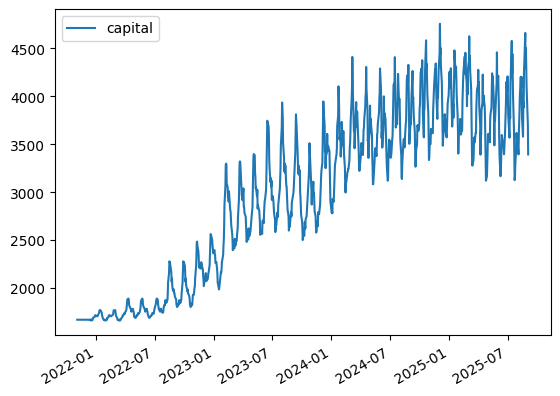

In [90]:
capital.rolling(5).sum().plot.line()
print(capital[-5:].sum())

### Debug optimal strategy with k=6 max trades per day

In [91]:
sim_params = SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)

res, capital_4trades = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 2315 in total, avg.bids per day 3.9437819420783646,  filled bids 1930, fill bids percent = 0.8336933045356372
  Stop loss events: count = 2, net loss = -152.82952941070212 
  Take profit events: count = 27, net profit = 1609.0017998742005 
  Start capital = 10000, Resulting capital: 19043.670645872284 
  CAGR in 4 years: 1.175 or 17.47 % of avg. growth per year


In [92]:
filter_stop_loss = (res.lower_entry==1) & (res.stop_loss==1)
print(f'Average real close price if not stop_loss: {res[filter_stop_loss].growth_future_30d.mean()}')
res[filter_stop_loss].head(10)

Average real close price if not stop_loss: 0.5739947630046407


,Close,Ticker,Date,rf_prob_30d,rf_pred_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
2152,58.07,CNC,2025-05-22,0.593983,4.0,0.561391,1.032547,0.568107,0.960737,0.053983,0.247145,176.296091,1,1,0,105.777655,-0.352592,105.425063
2156,56.41,CNC,2025-05-23,0.606418,1.0,0.586598,1.037405,0.576494,0.999468,0.066418,0.257381,203.876868,1,1,0,122.326121,-0.407754,121.918367


In [93]:
filter_take_profit = (res.lower_entry==1) & (res.take_profit==1) & (res.stop_loss==0)
print(f'Average real close price if not take_profit: {res[filter_take_profit].growth_future_30d.mean()}')
res[filter_take_profit].head(10)

Average real close price if not take_profit: 1.5964263884111762


,Close,Ticker,Date,rf_prob_30d,rf_pred_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
119,46.020000,TTD,2022-07-19,0.569318,3.0,1.365059,1.667753,0.910691,0.999565,0.029318,0.236476,78.825438,1,0,1,118.238158,-0.157651,118.080507
229,408.589996,FICO,2022-10-20,0.791798,2.0,1.520644,1.560709,0.979539,0.980225,0.251798,0.249816,89.702634,1,0,1,134.553951,-0.179405,134.374546
317,40.189999,COIN,2022-12-14,0.580371,1.0,1.397363,1.549888,0.785021,0.931575,0.040371,0.256236,107.724969,1,0,1,161.587453,-0.215450,161.372003
321,37.980000,COIN,2022-12-15,0.657621,2.0,1.539758,1.640074,0.830700,0.913902,0.117621,0.250868,101.517364,1,0,1,152.276047,-0.203035,152.073012
333,34.970001,COIN,2022-12-20,0.675852,1.0,2.134115,2.446097,0.902202,0.995139,0.135852,0.252080,121.189137,1,0,1,181.783706,-0.242378,181.541327
335,9.030000,WBD,2022-12-20,0.675123,2.0,1.707641,1.777409,0.976744,0.986711,0.135123,0.250728,120.539298,1,0,1,180.808947,-0.241079,180.567868
336,35.150002,COIN,2022-12-21,0.656276,1.0,2.122048,2.493030,0.897582,0.937411,0.116276,0.253145,135.324677,1,0,1,202.987016,-0.270649,202.716367
339,9.040000,WBD,2022-12-21,0.655547,2.0,1.703540,1.775442,0.975664,0.975664,0.115547,0.251559,134.476876,1,0,1,201.715314,-0.268954,201.446361
341,34.590000,COIN,2022-12-22,0.687033,2.0,2.064759,2.533391,0.912113,0.973403,0.147033,0.249750,123.344094,1,0,1,185.016141,-0.246688,184.769453
343,9.230000,WBD,2022-12-22,0.687650,1.0,1.660888,1.738895,0.955580,0.984832,0.147650,0.250798,123.861342,1,0,1,185.792014,-0.247723,185.544291


In [94]:
filter_no_stop_loss_no_take_profit = (res.lower_entry==1) & (res.take_profit==0) & (res.stop_loss==0)
print(f'Average real close price if no take_profit or stop loss: {res[filter_no_stop_loss_no_take_profit].growth_future_30d.mean()}')
res['realised_profit'] = res.future_net_return/res.investment
res[filter_no_stop_loss_no_take_profit][['growth_future_30d','realised_profit']].describe().T

Average real close price if no take_profit or stop loss: 1.0383788433183962


,count,mean,std,min,25%,50%,75%,max
growth_future_30d,1901.0,1.038379,0.112634,0.629798,0.970208,1.029737,1.101984,1.57185
realised_profit,1901.0,1.036379,0.112634,0.627798,0.968208,1.027737,1.099984,1.56985


capital    19043.670646
dtype: float64


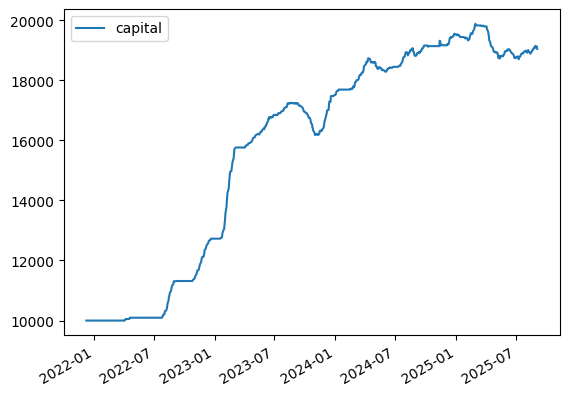

In [95]:
capital_4trades.rolling(30).sum().plot.line()
print(capital_4trades[-30:].sum())

### Debug optimal strategy with k=1 max trades per day

In [96]:
sim_params = SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)

res, capital_1_trade = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
 Count bids 587 in total, avg.bids per day 1.0,  filled bids 493, fill bids percent = 0.8398637137989778
  Stop loss events: count = 1, net loss = -406.1349995428376 
  Take profit events: count = 10, net profit = 2171.956820565276 
  Start capital = 10000, Resulting capital: 19677.591766929785 
  CAGR in 4 years: 1.184 or 18.44 % of avg. growth per year


In [97]:
# NO STOP LOSS events
filter_stop_loss = (res.lower_entry==1) & (res.stop_loss==1)
print(f'Average real close price if not stop_loss: {res[filter_stop_loss].growth_future_30d.mean()}')
res[filter_stop_loss].head(10)

Average real close price if not stop_loss: 0.5865981251922648


,Close,Ticker,Date,rf_prob_30d,rf_pred_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
547,56.41,CNC,2025-05-23,0.606418,1.0,0.586598,1.037405,0.576494,0.999468,0.066418,1.0,1010.286069,1,1,0,606.171641,-2.020572,604.151069


In [98]:
filter_take_profit = (res.lower_entry==1) & (res.take_profit==1) & (res.stop_loss==0)
print(f'Average real close price if not take_profit: {res[filter_take_profit].growth_future_30d.mean()}')
res[filter_take_profit].head(5)

Average real close price if not take_profit: 1.6460825198859321


,Close,Ticker,Date,rf_prob_30d,rf_pred_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
79,40.189999,COIN,2022-12-14,0.580371,1.0,1.397363,1.549888,0.785021,0.931575,0.040371,1.0,383.323730,1,0,1,574.985595,-0.766647,574.218947
83,34.970001,COIN,2022-12-20,0.675852,1.0,2.134115,2.446097,0.902202,0.995139,0.135852,1.0,491.396416,1,0,1,737.094625,-0.982793,736.111832
84,35.150002,COIN,2022-12-21,0.656276,1.0,2.122048,2.493030,0.897582,0.937411,0.116276,1.0,456.065485,1,0,1,684.098227,-0.912131,683.186096
85,9.230000,WBD,2022-12-22,0.687650,1.0,1.660888,1.738895,0.955580,0.984832,0.147650,1.0,410.431026,1,0,1,615.646540,-0.820862,614.825678
87,6.000000,PLTR,2022-12-27,0.689050,1.0,1.325000,1.535000,0.986667,0.991667,0.149050,1.0,402.870951,1,0,1,604.306426,-0.805742,603.500684


In [99]:
filter_no_stop_loss_no_take_profit = (res.lower_entry==1) & (res.take_profit==0) & (res.stop_loss==0)
print(f'Average real close price if no take_profit or stop loss: {res[filter_no_stop_loss_no_take_profit].growth_future_30d.mean()}')
res['realised_profit'] = res.future_net_return/res.investment
res[filter_no_stop_loss_no_take_profit][['growth_future_30d','realised_profit']].describe().T

Average real close price if no take_profit or stop loss: 1.040019109036203


,count,mean,std,min,25%,50%,75%,max
growth_future_30d,482.0,1.040019,0.113553,0.749988,0.9734,1.029537,1.097249,1.57185
realised_profit,482.0,1.038019,0.113553,0.747988,0.9714,1.027537,1.095249,1.56985


capital    19677.591767
dtype: float64


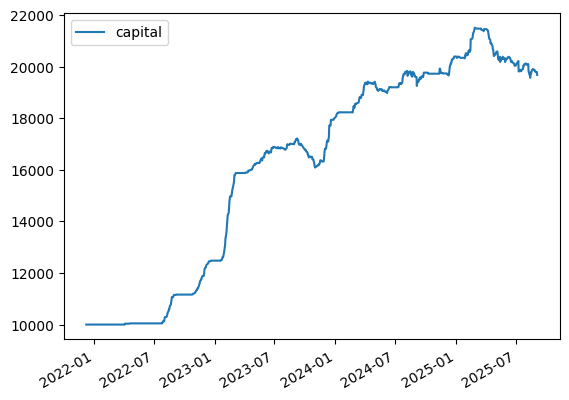

In [100]:
capital_1_trade.rolling(30).sum().plot.line()
print(capital_1_trade[-30:].sum())

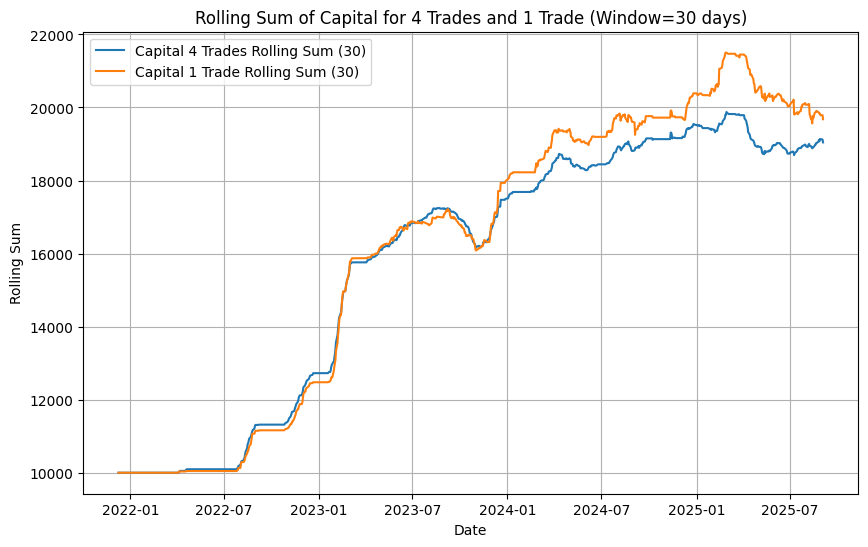

Capital 4 Trades Ending Sum: capital    19043.670646
dtype: float64
Capital 1 Trade Ending Sum: capital    19677.591767
dtype: float64


In [101]:
import matplotlib.pyplot as plt

# Assuming capital_6trades and capital_1_trade are defined and have the same index
capital_6trades_rolling = capital_4trades.rolling(30).sum()
capital_1_trade_rolling = capital_1_trade.rolling(30).sum()

# Plot the rolling sums on the same graph
plt.figure(figsize=(10, 6))
plt.plot(capital_6trades_rolling, label='Capital 4 Trades Rolling Sum (30)')
plt.plot(capital_1_trade_rolling, label='Capital 1 Trade Rolling Sum (30)')
plt.legend(loc='best')
plt.title('Rolling Sum of Capital for 4 Trades and 1 Trade (Window=30 days)')
plt.xlabel('Date')
plt.ylabel('Rolling Sum')
plt.grid(True)
plt.show()

# Print the ending values
print(f"Capital 4 Trades Ending Sum: {capital_4trades[-30:].sum()}")
print(f"Capital 1 Trade Ending Sum: {capital_1_trade[-30:].sum()}")

<Axes: >

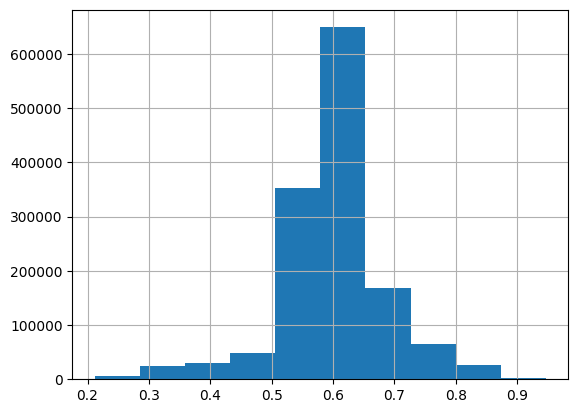

In [ ]:
df.rf_prob_30d.hist()



In [ ]:
df.rf_prob_30d.value_counts()


rf_prob_30d
0.679398    30
0.681503    23
0.673254    22
0.675458    20
0.690331    16
            ..
0.545501     1
0.538472     1
0.550005     1
0.552257     1
0.537172     1
Name: count, Length: 1343016, dtype: int64

In [103]:
TARGET_COL = "is_positive_growth_30d_future"
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in df.columns")
y_true = df[TARGET_COL].astype(int)



In [104]:
# --- 4) Helpers ---
def precision_at_k(y_true: pd.Series, y_scores: pd.Series, k: int) -> float:
    """
    Precision@k: Of the top k highest-scored samples, how many are positive?
    - Handles k > n by clipping to n
    - Handles NaNs by treating them as lowest score
    - Keeps index alignment correct
    """
    n = len(y_scores)
    if n == 0:
        return np.nan
    k = min(k, n)
    # Replace NaNs with -inf so they go to the bottom
    scores = y_scores.fillna(float("-inf")).to_numpy()
    # Argpartition is O(n) and faster than full sort for small k
    if k == n:
        topk_idx = np.argsort(scores)[::-1][:k]
    else:
        # get indices of k largest (unordered), then sort them to get true top order
        part = np.argpartition(scores, -k)[-k:]
        topk_idx = part[np.argsort(scores[part])[::-1]]
    # y_true is a Series; iloc keeps positional alignment
    topk_true = y_true.iloc[topk_idx]
    return float(topk_true.mean())


def lift_at_k(prec_k: float, base_rate: float) -> float:
    """Lift@k = precision@k / base_rate (>= 0)."""
    if base_rate == 0:
        return np.nan
    return float(prec_k / base_rate)

In [105]:
df.columns.to_list()

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'adj_close',
 'Volume',
 'Ticker',
 'year',
 'month',
 'weekday',
 'wom',
 'month_wom',
 'growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_252d',
 'growth_365d',
 'growth_future_30d',
 'is_positive_growth_30d_future',
 'sma10',
 'sma20',
 'growing_moving_average',
 'volatility',
 'sharpe',
 'high_minus_low_relative',
 'ln_volume',
 'ticker_type',
 'adx',
 'adxr',
 'apo',
 'aroon_up',
 'aroon_down',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macd_signal',
 'macd_hist',
 'macd_ext',
 'macd_signal_ext',
 'macd_hist_ext',
 'macd_fix',
 'macd_signal_fix',
 'macd_hist_fix',
 'mfi',
 'minus_di',
 'plus_di',
 'plus_dm',
 'mom',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'stoch_slowk',
 'stoch_slowd',
 'stoch_fastk',
 'stoch_fastd',
 'stochrsi_fastk',
 'stochrsi_fastd',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'trange',
 'ht_dcperiod',
 'ht_dcphase',
 'ht_phasor_in

In [106]:
pred_cols = [col for col in df.columns if col.startswith('pred')]

results = []
k_values = [5, 10, 20, 50, 100, 200]
base_rate = y_true.mean()

for col in pred_cols:
    y_scores = df[col]
    # Robust binarization (0.5 threshold by default). If your model outputs logits,
    # apply sigmoid first or adjust threshold as needed.
    y_pred = (y_scores >= 0.5).astype(int)

    # Some metrics need non-NaN scores
    scores_no_nan = y_scores.fillna(y_scores.min() - 1e9)

    row = {
        "model": col,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, scores_no_nan),
        "pr_auc": average_precision_score(y_true, scores_no_nan),  # area under PR curve
        "base_rate_%": base_rate * 100,
    }

    # precision@k and lift@k
    for k in k_values:
        p_at_k = precision_at_k(y_true, y_scores, k)
        row[f"precision@{k}"] = p_at_k
        row[f"lift@{k}"] = lift_at_k(p_at_k, base_rate)

    results.append(row)

metrics_df = (
    pd.DataFrame(results)
      .sort_values(["roc_auc", "pr_auc"], ascending=False)
      .reset_index(drop=True)
)

# Pretty display: show precision@k and lift@k together
cols_order = (
    ["model", "roc_auc", "pr_auc", "accuracy", "precision", "recall", "f1", "base_rate_%"]
    + sum(([f"precision@{k}", f"lift@{k}"] for k in k_values), [])
)
display(metrics_df[cols_order])


,model,roc_auc,pr_auc,accuracy,precision,recall,f1,base_rate_%,precision@5,lift@5,precision@10,lift@10,precision@20,lift@20,precision@50,lift@50,precision@100,lift@100,precision@200,lift@200
0,pred12_rf_thresh_65,0.556940,0.614217,0.508138,0.715972,0.251812,0.372584,57.996931,1.0,1.724229,1.0,1.724229,1.00,1.724229,0.66,1.137991,0.66,1.137991,0.605,1.043159
1,pred11_rf_thresh_50,0.553436,0.607265,0.620276,0.608070,0.971350,0.747931,57.996931,0.8,1.379383,0.9,1.551806,0.95,1.638018,0.98,1.689745,0.83,1.431110,0.730,1.258687
2,pred20_ens_ml50_and_momentum,0.519616,0.589818,0.525607,0.597648,0.557075,0.576649,57.996931,0.0,0.000000,0.0,0.000000,0.15,0.258634,0.22,0.379330,0.61,1.051780,0.575,0.991432
3,pred5_manual_vix_contrarian,0.512351,0.586317,0.462271,0.611831,0.199233,0.300586,57.996931,1.0,1.724229,1.0,1.724229,0.75,1.293172,0.38,0.655207,0.54,0.931084,0.495,0.853493
4,pred3_manual_declining_rates,0.509746,0.584799,0.505618,0.589950,0.483939,0.531712,57.996931,0.2,0.344846,0.2,0.344846,0.30,0.517269,0.38,0.655207,0.52,0.896599,0.605,1.043159
5,pred30_top10_daily,0.509169,0.585168,0.436490,0.674923,0.054749,0.101282,57.996931,0.6,1.034538,0.6,1.034538,0.65,1.120749,0.54,0.931084,0.68,1.172476,0.700,1.206960
6,pred13_rf_thresh_80,0.508488,0.585515,0.431644,0.777793,0.028033,0.054116,57.996931,0.6,1.034538,0.5,0.862115,0.55,0.948326,0.78,1.344899,0.75,1.293172,0.700,1.206960
7,pred15_rf_auto_rate_5p,0.508443,0.585408,0.431780,0.766769,0.029114,0.056098,57.996931,1.0,1.724229,0.9,1.551806,0.80,1.379383,0.76,1.310414,0.81,1.396626,0.770,1.327656
8,pred30_top5_daily,0.505157,0.582944,0.428818,0.686772,0.027855,0.053539,57.996931,0.2,0.344846,0.1,0.172423,0.40,0.689692,0.50,0.862115,0.60,1.034538,0.670,1.155234
9,pred15_rf_auto_rate_3p,0.504930,0.583942,0.425847,0.959365,0.010472,0.020717,57.996931,1.0,1.724229,1.0,1.724229,1.00,1.724229,1.00,1.724229,0.98,1.689745,0.980,1.689745


In [107]:
print(df.info())
print(df.describe(include="all").transpose())

# Missing values
missing_summary = df.isnull().mean().sort_values(ascending=False)
print("Missing % per column:\n", missing_summary.head(20))

# Class balance
print("Target balance:", y_true.value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372264 entries, 0 to 1372263
Columns: 642 entries, Date to pred22_ens_manual2plus_and_auto3p
dtypes: datetime64[ns](1), float64(151), int32(459), int64(2), int8(21), object(8)
memory usage: 4.0+ GB
None


/Users/sagardhal/Desktop/Practice/personal-stock/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



                                       count unique  top freq  \
Date                                 1372264    NaN  NaN  NaN   
Open                               1372240.0    NaN  NaN  NaN   
High                               1372240.0    NaN  NaN  NaN   
Low                                1372240.0    NaN  NaN  NaN   
Close                              1372240.0    NaN  NaN  NaN   
...                                      ...    ...  ...  ...   
pred30_top5_daily                  1372264.0    NaN  NaN  NaN   
pred30_top10_daily                 1372264.0    NaN  NaN  NaN   
pred20_ens_ml50_and_momentum       1372264.0    NaN  NaN  NaN   
pred21_ens_auto1p_or_top3          1372264.0    NaN  NaN  NaN   
pred22_ens_manual2plus_and_auto3p  1372264.0    NaN  NaN  NaN   

                                                            mean  \
Date                               2013-09-27 18:11:17.845079552   
Open                                                   92.457022   
High           

In [108]:
binary_cols = [c for c in df.columns if c.startswith("pred") and c != "rf_prob_30d"]
prob_cols   = ["rf_prob_30d"]  # extend if you add more prob outputs


In [109]:
for col in binary_cols:
    y_pred = df[col].fillna(0).astype(int)
    print(
        col,
        "Acc:", accuracy_score(y_true, y_pred),
        "Prec:", precision_score(y_true, y_pred, zero_division=0),
        "Rec:", recall_score(y_true, y_pred, zero_division=0),
        "F1:", f1_score(y_true, y_pred, zero_division=0),
    )


pred0_manual_cci Acc: 0.4234374726728968 Prec: 0.5679367570552504 Rec: 0.024552974037249754 F1: 0.04707098104490303
pred1_manual_prev_g1 Acc: 0.5022196895058094 Prec: 0.5705909523910858 Rec: 0.5727360338547327 F1: 0.5716614808488437
pred2_manual_prev_g1_and_snp Acc: 0.42003069380235875 Prec: 0.0 Rec: 0.0 F1: 0.0
pred3_manual_declining_rates Acc: 0.5056184524260637 Prec: 0.5899500196827177 Rec: 0.483938980060839 F1: 0.5317119569719092
pred4_manual_fed_easing Acc: 0.4761022660362729 Prec: 0.5691435349514301 Rec: 0.39790368037031126 F1: 0.4683624617869297
pred5_manual_vix_contrarian Acc: 0.462271108183265 Prec: 0.6118311641708114 Rec: 0.1992332928326324 F1: 0.3005855735454971
pred6_manual_stock_btc_momentum Acc: 0.4210428897063539 Prec: 0.7651775486827033 Rec: 0.002517996006890564 F1: 0.005019474257661336
pred10_rf_thresh_21 Acc: 0.5799693061976413 Prec: 0.5799693061976413 Rec: 1.0 F1: 0.7341526242600207
pred11_rf_thresh_50 Acc: 0.6202764191146893 Prec: 0.6080703316479831 Rec: 0.971349628

In [110]:
for k in [5, 10, 20, 50]:
    p_at_k = precision_at_k(y_true, df["rf_prob_30d"], k)
    print(f"rf_prob_30d | Precision@{k}: {p_at_k:.3f}, Lift@{k}: {lift_at_k(p_at_k, base_rate):.2f}")


rf_prob_30d | Precision@5: 1.000, Lift@5: 1.72
rf_prob_30d | Precision@10: 1.000, Lift@10: 1.72
rf_prob_30d | Precision@20: 1.000, Lift@20: 1.72
rf_prob_30d | Precision@50: 1.000, Lift@50: 1.72


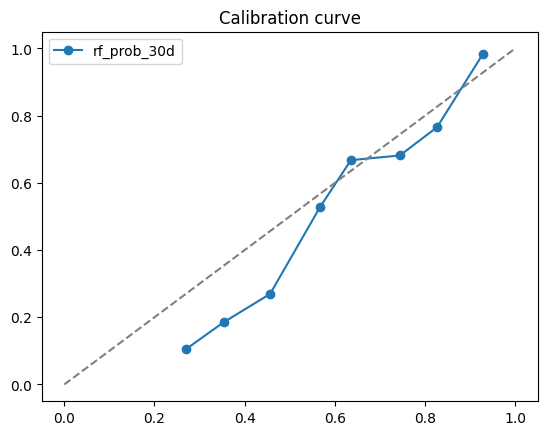

In [111]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_true, df["rf_prob_30d"], n_bins=10)
plt.plot(prob_pred, prob_true, marker="o", label="rf_prob_30d")
plt.plot([0,1],[0,1],"--", color="gray")
plt.legend(); plt.title("Calibration curve"); plt.show()


In [112]:
def simulate_threshold(y_true, y_scores, threshold=0.6):
    picks = (y_scores >= threshold).astype(int)
    return precision_score(y_true, picks), recall_score(y_true, picks)

for t in [0.4, 0.5, 0.6, 0.7]:
    prec, rec = simulate_threshold(y_true, df["rf_prob_30d"], t)
    print(f"rf_prob_30d τ={t}: Precision={prec:.3f}, Recall={rec:.3f}")


rf_prob_30d τ=0.4: Precision=0.594, Recall=0.991
rf_prob_30d τ=0.5: Precision=0.608, Recall=0.971
rf_prob_30d τ=0.6: Precision=0.674, Recall=0.592
rf_prob_30d τ=0.7: Precision=0.703, Recall=0.113


In [113]:
def simulate_binary_strategy(df, pred_col, return_col="growth_future_30d"):
    picks = df[df[pred_col] == 1]
    if picks.empty:
        return np.nan
    return {
        "avg_return": picks[return_col].mean(),
        "win_rate": (picks[return_col] > 0).mean(),
        "sharpe": picks[return_col].mean() / (picks[return_col].std() + 1e-9),
        "n_trades": len(picks),
    }

for col in binary_cols:
    print(col, simulate_binary_strategy(df, col))


pred0_manual_cci {'avg_return': np.float64(1.0156354621964798), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.280734184029704), 'n_trades': 34407}
pred1_manual_prev_g1 {'avg_return': np.float64(1.0156212260074475), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.657842801240522), 'n_trades': 798863}
pred2_manual_prev_g1_and_snp nan
pred3_manual_declining_rates {'avg_return': np.float64(1.022848588984539), 'win_rate': np.float64(1.0), 'sharpe': np.float64(7.219960772969457), 'n_trades': 652857}
pred4_manual_fed_easing {'avg_return': np.float64(1.018449702660138), 'win_rate': np.float64(1.0), 'sharpe': np.float64(6.796588317620806), 'n_trades': 556415}
pred5_manual_vix_contrarian {'avg_return': np.float64(1.027895282099551), 'win_rate': np.float64(1.0), 'sharpe': np.float64(7.238214457287888), 'n_trades': 259163}
pred6_manual_stock_btc_momentum {'avg_return': np.float64(1.056260609649023), 'win_rate': np.float64(1.0), 'sharpe': np.float64(12.84599857038672), 'n_trades': 2619}
p

In [114]:
def simulate_prob_threshold(df, prob_col="rf_prob_30d", return_col="growth_future_30d", tau=0.6):
    picks = df[df[prob_col] >= tau]
    if picks.empty:
        return np.nan
    return {
        "avg_return": picks[return_col].mean(),
        "win_rate": (picks[return_col] > 0).mean(),
        "sharpe": picks[return_col].mean() / (picks[return_col].std() + 1e-9),
        "n_trades": len(picks),
    }

for t in [0.4, 0.5, 0.6, 0.7,0.8,0.9,0.95]:
    print(f"τ={t}", simulate_prob_threshold(df, tau=t))


τ=0.4 {'avg_return': np.float64(1.023577983392457), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.045660680563602), 'n_trades': 1328426}
τ=0.5 {'avg_return': np.float64(1.0270957398284992), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.096891938063054), 'n_trades': 1271348}
τ=0.6 {'avg_return': np.float64(1.0412774057425824), 'win_rate': np.float64(1.0), 'sharpe': np.float64(7.9035795803913915), 'n_trades': 699390}
τ=0.7 {'avg_return': np.float64(1.0640688899801445), 'win_rate': np.float64(1.0), 'sharpe': np.float64(5.580350770673184), 'n_trades': 128181}
τ=0.8 {'avg_return': np.float64(1.104642966351848), 'win_rate': np.float64(1.0), 'sharpe': np.float64(6.064256491571287), 'n_trades': 28685}
τ=0.9 {'avg_return': np.float64(1.2690783040303806), 'win_rate': np.float64(1.0), 'sharpe': np.float64(7.082317612563434), 'n_trades': 1582}
τ=0.95 nan


In [115]:
def simulate_topk(df, prob_col="rf_prob_30d", return_col="growth_future_30d", k=20):
    ranked = df.sort_values(prob_col, ascending=False).head(k)
    return {
        "avg_return": ranked[return_col].mean(),
        "win_rate": (ranked[return_col] > 0).mean(),
        "sharpe": ranked[return_col].mean() / (ranked[return_col].std() + 1e-9),
        "n_trades": len(ranked),
    }

for k in [5, 10, 20, 50,100,200,250]:
    print(f"Top-{k}", simulate_topk(df, k=k))


Top-5 {'avg_return': np.float64(1.3859317010227108), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.892216123136203), 'n_trades': 5}
Top-10 {'avg_return': np.float64(1.3590716560620693), 'win_rate': np.float64(1.0), 'sharpe': np.float64(10.986172343696838), 'n_trades': 10}
Top-20 {'avg_return': np.float64(1.3496580405625804), 'win_rate': np.float64(1.0), 'sharpe': np.float64(10.26409626611731), 'n_trades': 20}
Top-50 {'avg_return': np.float64(1.3444489803007178), 'win_rate': np.float64(1.0), 'sharpe': np.float64(9.758318569939327), 'n_trades': 50}
Top-100 {'avg_return': np.float64(1.3224664925199932), 'win_rate': np.float64(1.0), 'sharpe': np.float64(9.40711795700165), 'n_trades': 100}
Top-200 {'avg_return': np.float64(1.3175627802740462), 'win_rate': np.float64(1.0), 'sharpe': np.float64(9.549090760494265), 'n_trades': 200}
Top-250 {'avg_return': np.float64(1.313056205095614), 'win_rate': np.float64(1.0), 'sharpe': np.float64(9.630313002683435), 'n_trades': 250}


In [116]:
import numpy as np
import pandas as pd
from typing import List, Optional, Dict, Tuple
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

def analyze_predictions(
    df: pd.DataFrame,
    target_col: str = "is_positive_growth_30d_future",
    return_col: str = "growth_future_30d",
    prob_cols: Optional[List[str]] = None,   # e.g. ["rf_prob_30d"]
    binary_cols: Optional[List[str]] = None, # e.g. [c for c in df if c.startswith("pred_")]
    k_values: List[int] = [5, 10, 20, 50, 100, 200],
    thresholds: List[float] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Unified EDA + Simulation for predictions (without calibration).

    Returns:
        metrics_df: rows per (strategy, variant) with classification metrics & precision@k/lift@k.
        simulations_df: rows per (strategy, variant) with investment metrics: avg_return, win_rate, sharpe, n_trades,
                        plus std_return, efficiency, ra_efficiency.
    """
    # ---------- helpers ----------
    def precision_at_k(y_true: pd.Series, y_scores: pd.Series, k: int) -> float:
        n = len(y_scores)
        if n == 0: return np.nan
        k = min(k, n)
        scores = y_scores.fillna(float("-inf")).to_numpy()
        if k == n:
            topk_idx = np.argsort(scores)[::-1][:k]
        else:
            part = np.argpartition(scores, -k)[-k:]
            topk_idx = part[np.argsort(scores[part])[::-1]]
        return float(y_true.iloc[topk_idx].mean())

    def lift_at_k(prec_k: float, base_rate: float) -> float:
        if base_rate == 0 or pd.isna(prec_k): return np.nan
        return float(prec_k / base_rate)

    def sharpe_ratio(returns: pd.Series, rf: float = 0.0) -> float:
        r = pd.to_numeric(returns, errors="coerce").dropna()
        if r.empty: return np.nan
        excess = r - rf
        std = excess.std(ddof=1)
        return float(excess.mean() / (std + 1e-12))

    def _safe_auc(y_true, scores):
        s = pd.to_numeric(scores, errors="coerce")
        if s.nunique(dropna=True) <= 1:
            return np.nan, np.nan
        s = s.fillna(s.min() - 1e9)
        return float(roc_auc_score(y_true, s)), float(average_precision_score(y_true, s))

    # ---------- inputs & guards ----------
    assert target_col in df.columns, f"Missing target_col: {target_col}"
    assert return_col in df.columns, f"Missing return_col: {return_col}"

    if prob_cols is None:
        prob_cols = [c for c in df.columns if c.endswith("_prob_30d") or c.startswith("rf_prob")]
    if binary_cols is None:
        binary_cols = [c for c in df.columns if c.startswith("pred") and c not in prob_cols]

    y_true = df[target_col].astype(int)
    base_rate = float(y_true.mean())

    metrics_rows: List[Dict] = []
    sim_rows: List[Dict] = []

    # ===== 1) Binary strategies (0/1) =====
    for col in binary_cols:
        y_pred = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

        row = {
            "strategy": col,
            "variant": "binary@0.5",
            "type": "binary",
            "base_rate": base_rate,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "roc_auc": np.nan,
            "pr_auc": np.nan,
        }
        for k in k_values:
            p_at_k = precision_at_k(y_true, y_pred, k)
            row[f"precision@{k}"] = p_at_k
            row[f"lift@{k}"] = lift_at_k(p_at_k, base_rate)
        metrics_rows.append(row)

        # Simulation: buy where label == 1
        #picks = df.loc[y_pred == 1, return_col]

        # after (factor -> simple)
        picks_factor = df.loc[y_pred == 1, return_col]
        picks = pd.to_numeric(picks_factor, errors="coerce") - 1.0
        std_ret = float(picks.std(ddof=1)) if len(picks) > 1 else np.nan
        efficiency = float(picks.mean() * len(picks)) if not picks.empty else np.nan
        ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan

        sim_rows.append({
            "strategy": col,
            "variant": "binary@0.5",
            "type": "binary",
            "n_trades": int(picks.notna().sum()),
            "avg_return": float(picks.mean()) if not picks.empty else np.nan,
            "win_rate": float((picks > 0).mean()) if not picks.empty else np.nan,
            "sharpe": sharpe_ratio(picks),
            "std_return": std_ret,
            "efficiency": efficiency,
            "ra_efficiency": ra_efficiency,
        })

    # ===== 2) Probabilistic strategies =====
    for col in prob_cols:
        scores = pd.to_numeric(df[col], errors="coerce")

        # Classifier view at 0.5
        y_pred = (scores.fillna(0) >= 0.5).astype(int)
        roc_auc, pr_auc = _safe_auc(y_true, scores)

        row = {
            "strategy": col,
            "variant": "prob_raw",
            "type": "prob",
            "base_rate": base_rate,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "roc_auc": roc_auc,
            "pr_auc": pr_auc,
        }
        for k in k_values:
            p_at_k = precision_at_k(y_true, scores, k)
            row[f"precision@{k}"] = p_at_k
            row[f"lift@{k}"] = lift_at_k(p_at_k, base_rate)
        metrics_rows.append(row)

        # Threshold simulations
        for t in thresholds:
            #picks = df.loc[scores >= t, return_col]
            # after (factor -> simple)
            mask = scores >= t                     # <-- use τ here

            picks_factor = df.loc[mask, return_col]

            picks = pd.to_numeric(picks_factor, errors="coerce") - 1.0
            std_ret = float(picks.std(ddof=1)) if len(picks) > 1 else np.nan
            efficiency = float(picks.mean() * len(picks)) if not picks.empty else np.nan
            ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan

            sim_rows.append({
                "strategy": col,
                "variant": f"τ={t:.2f}",
                "type": "prob",
                "n_trades": int(picks.notna().sum()),
                "avg_return": float(picks.mean()) if not picks.empty else np.nan,
                "win_rate": float((picks > 0).mean()) if not picks.empty else np.nan,
                "sharpe": sharpe_ratio(picks),
                "std_return": std_ret,
                "efficiency": efficiency,
                "ra_efficiency": ra_efficiency,
            })

        # Top-K simulations
        sorted_idx = scores.sort_values(ascending=False).index
        for k in k_values:
            ranked = df.loc[sorted_idx][:k]
            #picks = ranked[return_col]

            # after (factor -> simple)
            picks_factor = ranked[return_col]      # <-- use ranked rows


            picks = pd.to_numeric(picks_factor, errors="coerce") - 1.0
            std_ret = float(picks.std(ddof=1)) if len(picks) > 1 else np.nan
            efficiency = float(picks.mean() * len(picks)) if not picks.empty else np.nan
            ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan

            sim_rows.append({
                "strategy": col,
                "variant": f"top-{k}",
                "type": "prob",
                "n_trades": int(picks.notna().sum()),
                "avg_return": float(picks.mean()) if not picks.empty else np.nan,
                "win_rate": float((picks > 0).mean()) if not picks.empty else np.nan,
                "sharpe": sharpe_ratio(picks),
                "std_return": std_ret,
                "efficiency": efficiency,
                "ra_efficiency": ra_efficiency,
            })

    metrics_df = pd.DataFrame(metrics_rows).reset_index(drop=True)
    simulations_df = pd.DataFrame(sim_rows).reset_index(drop=True)
    return metrics_df, simulations_df


In [117]:
prob_cols = ["rf_prob_30d"]
binary_cols = [c for c in df.columns if c.startswith("pred")]

metrics_df, simulations_df = analyze_predictions(
    df.query('split == "test"'),
    target_col="is_positive_growth_30d_future",
    return_col="growth_future_30d",
    prob_cols=prob_cols,
    binary_cols=binary_cols,
    k_values=[5, 10, 20, 50],
    thresholds=[0.4, 0.5, 0.6, 0.7,0.8,0.9,0.95]
)



In [118]:
df.split.unique()

array(['train', 'validation', 'test'], dtype=object)

In [119]:

print("=== METRICS ===")
metrics_df.head(20)


=== METRICS ===


,strategy,variant,type,base_rate,accuracy,precision,recall,f1,roc_auc,pr_auc,precision@5,lift@5,precision@10,lift@10,precision@20,lift@20,precision@50,lift@50
0,pred0_manual_cci,binary@0.5,binary,0.533782,0.467650,0.529846,0.023815,0.045581,NaN,NaN,0.4,0.749369,0.6,1.124054,0.50,0.936711,0.40,0.749369
1,pred1_manual_prev_g1,binary@0.5,binary,0.533782,0.483984,0.516137,0.532270,0.524079,NaN,NaN,0.6,1.124054,0.8,1.498738,0.85,1.592409,0.88,1.648612
2,pred2_manual_prev_g1_and_snp,binary@0.5,binary,0.533782,0.466218,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.000000,0.2,0.374685,0.25,0.468356,0.40,0.749369
3,pred3_manual_declining_rates,binary@0.5,binary,0.533782,0.508148,0.665206,0.158148,0.255543,NaN,NaN,1.0,1.873423,0.6,1.124054,0.60,1.124054,0.66,1.236459
4,pred4_manual_fed_easing,binary@0.5,binary,0.533782,0.441426,0.455658,0.238635,0.313228,NaN,NaN,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.28,0.524558
5,pred5_manual_vix_contrarian,binary@0.5,binary,0.533782,0.510330,0.600789,0.246305,0.349377,NaN,NaN,0.8,1.498738,0.9,1.686081,0.95,1.779752,0.92,1.723549
6,pred6_manual_stock_btc_momentum,binary@0.5,binary,0.533782,0.466218,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.000000,0.2,0.374685,0.25,0.468356,0.40,0.749369
7,pred10_rf_thresh_21,binary@0.5,binary,0.533782,0.533782,0.533782,1.000000,0.696034,NaN,NaN,0.0,0.000000,0.2,0.374685,0.25,0.468356,0.40,0.749369
8,pred11_rf_thresh_50,binary@0.5,binary,0.533782,0.609699,0.587946,0.898516,0.710787,NaN,NaN,0.0,0.000000,0.0,0.000000,0.25,0.468356,0.58,1.086585
9,pred12_rf_thresh_65,binary@0.5,binary,0.533782,0.508194,0.864148,0.093309,0.168432,NaN,NaN,1.0,1.873423,1.0,1.873423,1.00,1.873423,0.98,1.835954


In [120]:
print("\n=== SIMULATIONS ===")
(simulations_df)


=== SIMULATIONS ===


,strategy,variant,type,n_trades,avg_return,win_rate,sharpe,std_return,efficiency,ra_efficiency
0,pred0_manual_cci,binary@0.5,binary,5696,0.013123,0.547051,0.095997,0.136703,74.749240,546.801476
1,pred1_manual_prev_g1,binary@0.5,binary,130690,0.008855,0.534180,0.067711,0.130772,1157.210358,8849.098673
2,pred2_manual_prev_g1_and_snp,binary@0.5,binary,0,NaN,NaN,NaN,NaN,NaN,NaN
3,pred3_manual_declining_rates,binary@0.5,binary,30129,0.054790,0.665206,0.393380,0.139280,1650.766896,11852.142943
4,pred4_manual_fed_easing,binary@0.5,binary,66370,-0.004688,0.499774,-0.030613,0.153121,-311.109532,-2031.793788
5,pred5_manual_vix_contrarian,binary@0.5,binary,51955,0.033943,0.600789,0.250513,0.135494,1763.513979,13015.402320
6,pred6_manual_stock_btc_momentum,binary@0.5,binary,0,NaN,NaN,NaN,NaN,NaN,NaN
7,pred10_rf_thresh_21,binary@0.5,binary,237417,0.014654,0.546115,0.107504,0.136310,3479.086457,25523.266781
8,pred11_rf_thresh_50,binary@0.5,binary,193671,0.029951,0.603059,0.219880,0.136214,5800.614722,42584.423517
9,pred12_rf_thresh_65,binary@0.5,binary,13684,0.118370,0.864148,0.865629,0.136745,1619.779018,11845.264070


In [121]:
(simulations_df[["strategy","variant","n_trades","avg_return","win_rate"]]
        .sort_values(["avg_return","n_trades"], ascending= False).head(20))


,strategy,variant,n_trades,avg_return,win_rate
28,rf_prob_30d,top-5,5,0.201540,1.000000
29,rf_prob_30d,top-10,10,0.179435,1.000000
31,rf_prob_30d,top-50,50,0.178470,1.000000
13,pred15_rf_auto_rate_3p,binary@0.5,598,0.163857,0.989967
30,rf_prob_30d,top-20,20,0.163833,1.000000
10,pred13_rf_thresh_80,binary@0.5,3944,0.151449,0.951826
25,rf_prob_30d,τ=0.80,3944,0.151449,0.951826
14,pred15_rf_auto_rate_5p,binary@0.5,4116,0.151273,0.951409
9,pred12_rf_thresh_65,binary@0.5,13684,0.118370,0.864148
24,rf_prob_30d,τ=0.70,10950,0.117856,0.876164


In [122]:
(simulations_df.query("type=='prob'")[["strategy","variant","n_trades","avg_return","win_rate"]]
        .sort_values(["avg_return","n_trades"], ascending= False).head(20))


,strategy,variant,n_trades,avg_return,win_rate
28,rf_prob_30d,top-5,5,0.201540,1.000000
29,rf_prob_30d,top-10,10,0.179435,1.000000
31,rf_prob_30d,top-50,50,0.178470,1.000000
30,rf_prob_30d,top-20,20,0.163833,1.000000
25,rf_prob_30d,τ=0.80,3944,0.151449,0.951826
24,rf_prob_30d,τ=0.70,10950,0.117856,0.876164
23,rf_prob_30d,τ=0.60,28961,0.093962,0.799938
22,rf_prob_30d,τ=0.50,193671,0.029951,0.603059
21,rf_prob_30d,τ=0.40,211569,0.025929,0.586972
26,rf_prob_30d,τ=0.90,0,NaN,NaN


In [123]:
import numpy as np
import pandas as pd

def pareto_front(df: pd.DataFrame, cols=("avg_return","sharpe","n_trades")) -> pd.DataFrame:
    """Return non-dominated strategies on the given columns (maximize all)."""
    if df.empty:
        return df
    keep = []
    vals = df[list(cols)].to_numpy()
    for i, vi in enumerate(vals):
        dominated = False
        for j, vj in enumerate(vals):
            if j == i: 
                continue
            if np.all(np.nan_to_num(vj, nan=-1e9) >= np.nan_to_num(vi, nan=-1e9)) and \
               np.any(np.nan_to_num(vj, nan=-1e9) >  np.nan_to_num(vi, nan=-1e9)):
                dominated = True
                break
        if not dominated:
            keep.append(i)
    return df.iloc[keep].sort_values(list(cols), ascending=False)

def rank_strategies(
    simulations_df: pd.DataFrame,
    prefer_type: str = "prob",     # focus on prob strategies by default
    min_trades: int = 5,           # basic capacity filter
    weights=(1.0, 2.0, 0.2),       # (avg_return, sharpe, log(1+n_trades)) for utility
) -> dict:
    """
    Returns several ranked views:
      - 'filtered': filtered sims
      - 'pareto': Pareto frontier (avg_return, sharpe, n_trades)
      - 'top_utility': by weighted utility
      - 'top_efficiency': by avg_return * n_trades
      - 'top_ra_efficiency': risk-adjusted efficiency
    """
    if simulations_df.empty:
        return {"filtered": simulations_df, "pareto": simulations_df,
                "top_utility": simulations_df, "top_efficiency": simulations_df,
                "top_ra_efficiency": simulations_df}

    sdf = simulations_df.copy()
    if prefer_type:
        sdf = sdf[sdf["type"] == prefer_type].copy()
    if min_trades is not None:
        sdf = sdf[sdf["n_trades"] >= min_trades].copy()

    # Utility score
    w1, w2, w3 = weights
    sdf["utility"] = (
        w1 * sdf["avg_return"].fillna(-1e9) +
        w2 * sdf["sharpe"].fillna(-1e9) +
        w3 * np.log1p(sdf["n_trades"].clip(lower=0))
    )

    views = {
        "filtered": sdf.sort_values(["strategy","variant"]).reset_index(drop=True),
        "pareto": pareto_front(sdf, cols=("avg_return","sharpe","n_trades")).reset_index(drop=True),
        "top_utility": sdf.sort_values("utility", ascending=False).head(20).reset_index(drop=True),
        "top_efficiency": sdf.sort_values("efficiency", ascending=False).head(20).reset_index(drop=True),
        "top_ra_efficiency": sdf.sort_values("ra_efficiency", ascending=False).head(20).reset_index(drop=True),
    }
    return views


In [124]:
# Select best strategies with multiple lenses
views = rank_strategies(simulations_df, prefer_type="prob", min_trades=5, weights=(1.0, 2.0, 0.2))

pareto_df         = views["pareto"]
top_utility_df    = views["top_utility"]
top_eff_df        = views["top_efficiency"]
top_ra_eff_df     = views["top_ra_efficiency"]

print("Pareto frontier:\n", pareto_df.head(10))
print("\nTop by utility:\n", top_utility_df.head(10))
print("\nTop by efficiency:\n", top_eff_df.head(10))
print("\nTop by risk-adjusted efficiency:\n", top_ra_eff_df.head(10))

Pareto frontier:
       strategy variant  type  n_trades  avg_return  win_rate    sharpe  \
0  rf_prob_30d   top-5  prob         5    0.201540  1.000000  1.832526   
1  rf_prob_30d  top-10  prob        10    0.179435  1.000000  2.205331   
2  rf_prob_30d  top-50  prob        50    0.178470  1.000000  2.554096   
3  rf_prob_30d  τ=0.80  prob      3944    0.151449  0.951826  1.291753   
4  rf_prob_30d  τ=0.70  prob     10950    0.117856  0.876164  0.921409   
5  rf_prob_30d  τ=0.60  prob     28961    0.093962  0.799938  0.701810   
6  rf_prob_30d  τ=0.50  prob    193671    0.029951  0.603059  0.219880   
7  rf_prob_30d  τ=0.40  prob    211569    0.025929  0.586972  0.192445   

   std_return   efficiency  ra_efficiency   utility  
0    0.109979     1.007698       9.162631  4.224944  
1    0.081364     1.794346      22.053314  5.069676  
2    0.069876     8.923477     127.704775  6.073026  
3    0.117243   597.313652    5094.672782  4.390995  
4    0.127909  1290.526072   10089.431984  3.

In [125]:
import numpy as np
import pandas as pd
from typing import List, Optional, Dict, Tuple

# ----------------------------
# Utilities
# ----------------------------
def _ensure_dt(s: pd.Series) -> pd.Series:
    s = pd.to_datetime(s, errors="coerce")
    if s.isna().any():
        raise ValueError("Some dates could not be parsed. Check your date_col.")
    return s

def _max_drawdown_from_equity(equity: pd.Series) -> Tuple[float, float]:
    """Return (max_dd_abs, max_dd_pct). equity must be indexed by date and positive."""
    if equity.empty:
        return 0.0, 0.0
    peaks = equity.cummax()
    dd = equity - peaks
    dd_pct = equity / peaks - 1.0
    return float(dd.min()), float(dd_pct.min())  # negatives

def _sharpe(series: pd.Series, rf: float = 0.0) -> float:
    x = pd.to_numeric(series, errors="coerce").dropna()
    if x.empty:
        return np.nan
    excess = x - rf
    std = excess.std(ddof=1)
    return float(excess.mean() / (std + 1e-12))

# ----------------------------
# Core simulator
# ----------------------------
def simulate_from_predictions(
    df: pd.DataFrame,
    date_col: str,
    return_col: str = "growth_future_30d",     # realized forward *factor* (1+r), e.g., 1.03 for +3%
    prob_cols: Optional[List[str]] = None,     # e.g., ["rf_prob_30d", "xgb_prob_30d"]
    binary_cols: Optional[List[str]] = None,   # e.g., all columns starting with "pred_"
    k_values: List[int] = (5, 10, 20, 50),     # per-date Top-K by prob
    prob_thresholds: List[float] = (0.5,0.55,0.6,0.65,0.7,0.75, 0.8,0.85, 0.9,0.95),  # per-date prob cuts (global thresholds)
    hold_days: int = 30,                       # holding window in days
    invest_per_trade: float = 1000.0,          # notional per position
    fee_rate: float = 0.0005,                  # round-trip fee as fraction of notional (e.g., 5 bps)
    split_col: Optional[str] = None,           # if you want to restrict to a split
    split_name: Optional[str] = None,          # e.g., "test"
    risk_free_annual: float = 0.0,             # set to e.g. 0.05 for 5% annual US T-bill equiv
) -> pd.DataFrame:
    """
    Returns a summary DataFrame: one row per (strategy, variant) with:
      n_trades, avg_return, win_rate, per_trade_sharpe, daily_sharpe,
      capital_required, net_pnl, max_dd_abs, max_dd_pct, cagr,
      avg_positions/day, p75_positions/day, efficiency, ra_efficiency.

    NOTE: `return_col` must be a *factor* (1+r). We convert to simple returns internally (r = factor - 1).
    """
    assert return_col in df.columns, f"{return_col} not in df"
    assert date_col in df.columns, f"{date_col} not in df"

    # Filter to split if requested
    work = df.copy()
    if split_col and split_name:
        work = work.loc[work[split_col] == split_name].copy()
        if work.empty:
            raise ValueError(f"No rows found for {split_col} == {split_name}")

    # Autodetect columns if not provided
    if prob_cols is None:
        prob_cols = [c for c in work.columns if c.endswith("_prob_30d") or c.startswith("rf_prob")]
    if binary_cols is None:
        binary_cols = [c for c in work.columns if c.lower().startswith("pred") and c not in prob_cols]

    # Guard
    if len(prob_cols) == 0 and len(binary_cols) == 0:
        raise ValueError("No strategies found. Provide prob_cols and/or binary_cols.")

    # Prepare
    work = work.copy()
    work[date_col] = _ensure_dt(work[date_col])
    work = work.sort_values(date_col).reset_index(drop=True)

    # Sanity: ensure return_col looks like a factor (~1.0 median)
    s = pd.to_numeric(work[return_col], errors="coerce").dropna()
    if not (0.5 < s.median() < 1.5):
        raise ValueError(
            f"{return_col} doesn't look like a factor (1+r). "
            f"If it's already simple returns, adjust the code to skip '- 1.0'. "
            f"Median value: {s.median():.4f}"
        )

    # Risk-free per trade (approx over hold_days)
    rf_per_trade = (1.0 + risk_free_annual)**(hold_days/365.25) - 1.0 if risk_free_annual > 0 else 0.0

    summaries: List[Dict] = []

    # Helper: compute summary from selected rows ("trades")
    def summarize_trades(trades: pd.DataFrame, label_strategy: str, label_variant: str) -> Dict:
        # --- Realized returns per trade (FACTOR -> SIMPLE) ---
        ret_factor = pd.to_numeric(trades[return_col], errors="coerce").dropna()
        ret = ret_factor - 1.0                     # simple returns (e.g., 1.03 -> 0.03)
        n_trades = int(len(ret))

        if n_trades == 0:
            return {
                "strategy": label_strategy, "variant": label_variant,
                "n_trades": 0, "avg_return": np.nan, "win_rate": np.nan,
                "per_trade_sharpe": np.nan, "daily_sharpe": np.nan,
                "capital_required": 0.0, "net_pnl": 0.0,
                "max_dd_abs": 0.0, "max_dd_pct": 0.0, "cagr": 0.0,
                "avg_pos_per_day": 0.0, "p75_pos_per_day": 0.0,
                "efficiency": np.nan, "ra_efficiency": np.nan
            }

        # --- Per-trade economics (use SIMPLE return) ---
        gross = invest_per_trade * ret              # $ P&L per trade before fees
        fees  = -invest_per_trade * fee_rate        # constant round-trip fee per trade
        net_per_trade = gross + fees

        net_pnl = float(net_per_trade.sum())
        avg_return = float(ret.mean())
        win_rate = float((ret > 0).mean())
        per_trade_sharpe = _sharpe(ret, rf=rf_per_trade)

        # Build entry/exit dates for concurrency & daily P&L
        twd = trades.copy()
        twd["_entry"] = pd.to_datetime(twd[date_col])
        twd["_exit"]  = twd["_entry"] + pd.Timedelta(days=hold_days - 1)

        # --- Daily P&L (book on EXIT day) ---
        daily = (
            pd.DataFrame({"date": twd["_exit"], "pnl": net_per_trade.values})
            .groupby("date")["pnl"].sum()
        )

        # --- Active positions per day via difference array (vectorized) ---
        start_day = twd["_entry"].min()
        end_day   = twd["_exit"].max()
        days = pd.date_range(start_day, end_day, freq="D")
        idx = pd.Index(days, name="date")

        delta = pd.Series(0.0, index=idx)
        entry_counts = twd["_entry"].value_counts()
        exit_counts  = (twd["_exit"] + pd.Timedelta(days=1)).value_counts()
        delta = delta.add(entry_counts, fill_value=0.0)
        delta = delta.add(-exit_counts, fill_value=0.0)
        active_pos = delta.cumsum()

        avg_pos = float(active_pos.mean())
        p75_pos = float(active_pos.quantile(0.75))
        pos_for_cap = max(avg_pos, p75_pos, 1.0)          # ≥1 position equivalent
        capital_required = float(invest_per_trade * pos_for_cap)

        # --- Equity & drawdown ---
        daily_all = pd.Series(0.0, index=idx)
        daily_all.loc[daily.index] = daily.values
        equity = capital_required + daily_all.cumsum()

        max_dd_abs, max_dd_pct = _max_drawdown_from_equity(equity)

        # --- Daily Sharpe: time-weighted by capital in use ---
        cap_in_use = invest_per_trade * active_pos
        daily_ret_proxy = (daily_all / cap_in_use.replace(0, np.nan)).fillna(0.0)
        daily_sharpe = _sharpe(daily_ret_proxy, rf=0.0)

        # --- CAGR over the full backtest interval ---
        years = max((idx[-1] - idx[0]).days / 365.25, 0.5)   # ≥ 6 months
        starting = max(capital_required, invest_per_trade)
        ending   = float(equity.iloc[-1])
        cagr = float((ending / starting) ** (1.0 / years) - 1.0)

        # Custom efficiency metrics
        efficiency = float(avg_return * n_trades)
        std_ret = float(ret.std(ddof=1)) if n_trades > 1 else np.nan
        ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan

        return {
            "strategy": label_strategy, "variant": label_variant,
            "n_trades": n_trades, "avg_return": avg_return, "win_rate": win_rate,
            "per_trade_sharpe": per_trade_sharpe, "daily_sharpe": daily_sharpe,
            "capital_required": capital_required, "net_pnl": net_pnl,
            "max_dd_abs": max_dd_abs, "max_dd_pct": max_dd_pct, "cagr": cagr,
            "avg_pos_per_day": avg_pos, "p75_pos_per_day": p75_pos,
            "efficiency": efficiency, "ra_efficiency": ra_efficiency
        }

    # ---------------------------------
    # A) Binary strategies (per-date)
    # ---------------------------------
    for col in (binary_cols or []):
        if col not in work.columns:
            continue
        trades = work.loc[work[col].astype(float) == 1.0, [date_col, return_col]].copy()
        summaries.append(summarize_trades(trades, col, "binary@1"))

    # ---------------------------------
    # B) Prob strategies: per-date Top-K & thresholds
    # ---------------------------------
    for col in (prob_cols or []):
        if col not in work.columns:
            continue
        scores = pd.to_numeric(work[col], errors="coerce")

        # Top-K per date
        tmp = work.assign(_score=scores).dropna(subset=["_score"])
        g = tmp.groupby(date_col)
        for k in k_values:
            picks = (
                g.apply(lambda d: d.nlargest(k, columns="_score"))
                 .reset_index(level=0, drop=True)
                 [[date_col, return_col]]
            )
            summaries.append(summarize_trades(picks, col, f"top-{k}"))

        # Threshold (scores >= τ)
        for t in prob_thresholds:
            picks = work.loc[scores >= t, [date_col, return_col]]
            summaries.append(summarize_trades(picks, col, f"τ={t:.2f}"))

    result = pd.DataFrame(summaries)
    if not result.empty:
        result = result.sort_values(["strategy", "variant"]).reset_index(drop=True)
    return result


In [126]:
# Example wiring (tweak names if yours differ)
summary = simulate_from_predictions(
    df=df,                      # your loaded predictions dataframe
    date_col="Date",                  # <- your timestamp column
    return_col="growth_future_30d",   # realized forward return
    prob_cols=["rf_prob_30d"],        # add more prob columns if you have them
    binary_cols=[c for c in df.columns if c.startswith("pred")],
    k_values=[5, 10, 20, 50,75,100],
    prob_thresholds=[0.6, 0.65,0.7,0.75, 0.8,0.85, 0.9,0.95],
    hold_days=30,
    invest_per_trade=1000.0,
    fee_rate=0.0005,
    split_col="split",                   # or "split"
    split_name="test",                  # or "test"
    risk_free_annual=0.05              # set to 0.05 to include a 5% annual RF in per-trade Sharpe
)


hold_days = 30  # or whatever you used
summary = summary.copy()

# Per-trade annualization (geometric, safer)
summary["per_trade_annualized"] = np.exp(
    (365/hold_days) * np.log1p(summary["avg_return"].clip(lower=-0.999999)).replace([-np.inf, np.inf], np.nan)
) - 1

# Pretty %
for col in ["avg_return", "per_trade_annualized", "cagr"]:
    summary[f"{col}_%"] = (summary[col] * 100).round(2)



/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/3512241619.py:208: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/3512241619.py:208: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_13607/3512241619.py:208: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. Thi

In [127]:
summary.loc[:, ["strategy","variant","n_trades",
                "avg_return_%","win_rate","per_trade_annualized_%","cagr_%"]]

,strategy,variant,n_trades,avg_return_%,win_rate,per_trade_annualized_%,cagr_%
0,pred0_manual_cci,binary@1,5696,1.31,0.547051,17.19,10.19
1,pred10_rf_thresh_21,binary@1,237417,1.47,0.546115,19.36,13.47
2,pred11_rf_thresh_50,binary@1,193671,3.00,0.603059,43.20,20.71
3,pred12_rf_thresh_65,binary@1,13684,11.84,0.864148,290.05,71.52
4,pred13_rf_thresh_80,binary@1,3944,15.14,0.951826,456.09,95.73
5,pred14_rf_thresh_90,binary@1,0,NaN,NaN,NaN,0.00
6,pred15_rf_auto_rate_1p,binary@1,0,NaN,NaN,NaN,0.00
7,pred15_rf_auto_rate_3p,binary@1,598,16.39,0.989967,533.55,86.56
8,pred15_rf_auto_rate_5p,binary@1,4116,15.13,0.951409,455.06,95.60
9,pred1_manual_prev_g1,binary@1,130690,0.89,0.534180,11.32,7.23


In [128]:
summary.sort_values(
    by=["avg_return", "n_trades"],
    ascending=[False, True],     # high avg_return first, then fewer trades first
    na_position="last"
)

# 1) avg_return (per-trade, over the hold window) or “Average 30-day return per trade: +X%.”
# 2) Cagr : The annualized growth rate of your portfolio equity over the whole backtest, starting with capital_required and adding daily P&L (we book P&L on exit day) “Run as a portfolio with realistic concurrency, the strategy achieved a CAGR of Z% over the backtest period.”

,strategy,variant,n_trades,avg_return,win_rate,per_trade_sharpe,daily_sharpe,capital_required,net_pnl,max_dd_abs,max_dd_pct,cagr,avg_pos_per_day,p75_pos_per_day,efficiency,ra_efficiency,per_trade_annualized,avg_return_%,per_trade_annualized_%,cagr_%
7,pred15_rf_auto_rate_3p,binary@1,598,0.163857,0.989967,1.772519,0.213857,2.670000e+05,9.768757e+04,0.000000e+00,0.000000,0.865604,118.807947,267.00,97.986574,1086.593945,5.335478,16.39,533.55,86.56
32,rf_prob_30d,τ=0.85,19,0.161752,1.000000,2.065902,0.139556,3.825503e+03,3.063792e+03,0.000000e+00,0.000000,2.243191,3.825503,2.00,3.073292,40.251360,5.197470,16.18,519.75,224.32
4,pred13_rf_thresh_80,binary@1,3944,0.151449,0.951826,1.257504,0.292522,1.492000e+06,5.953417e+05,0.000000e+00,0.000000,0.957264,758.461538,1492.00,597.313652,5094.672782,4.560867,15.14,456.09,95.73
31,rf_prob_30d,τ=0.80,3944,0.151449,0.951826,1.257504,0.292522,1.492000e+06,5.953417e+05,0.000000e+00,0.000000,0.957264,758.461538,1492.00,597.313652,5094.672782,4.560867,15.14,456.09,95.73
8,pred15_rf_auto_rate_5p,binary@1,4116,0.151273,0.951409,1.249275,0.295359,1.557000e+06,6.205820e+05,0.000000e+00,0.000000,0.956013,791.538462,1557.00,622.639957,5282.227359,4.550557,15.13,455.06,95.60
30,rf_prob_30d,τ=0.75,8455,0.132817,0.911177,1.028477,0.322350,2.848000e+06,1.118743e+06,0.000000e+00,0.000000,0.939939,1575.465839,2848.00,1122.970344,8966.863715,3.559793,13.28,355.98,93.99
3,pred12_rf_thresh_65,binary@1,13684,0.118370,0.864148,0.836264,0.145776,3.520755e+05,1.612937e+06,0.000000e+00,0.000000,0.715202,352.075472,0.00,1619.779018,11845.264070,2.900543,11.84,290.05,71.52
28,rf_prob_30d,τ=0.65,13684,0.118370,0.864148,0.836264,0.145776,3.520755e+05,1.612937e+06,0.000000e+00,0.000000,0.715202,352.075472,0.00,1619.779018,11845.264070,2.900543,11.84,290.05,71.52
29,rf_prob_30d,τ=0.70,10950,0.117856,0.876164,0.890016,0.379092,3.403750e+06,1.285051e+06,0.000000e+00,0.000000,0.897616,1978.915663,3403.75,1290.526072,10089.431984,2.878787,11.79,287.88,89.76
12,pred22_ens_manual2plus_and_auto3p,binary@1,8,0.096045,1.000000,2.450036,0.179605,8.000000e+03,7.643600e+02,0.000000e+00,0.000000,0.200219,7.741935,8.00,0.768360,20.455493,2.051959,9.60,205.20,20.02


In [129]:
# Check if your returns are realistic
ret_stats = df['growth_future_30d'].describe()
print(f"Return distribution:\n{ret_stats}")

# Check win rate vs market
market_win_rate = (df['growth_future_30d'] > 1.0).mean()
print(f"Market win rate: {market_win_rate:.3f}")


Return distribution:
count    1.372264e+06
mean     1.019767e+00
std      1.287381e-01
min      2.264101e-04
25%      9.568989e-01
50%      1.018257e+00
75%      1.078546e+00
max      5.394737e+00
Name: growth_future_30d, dtype: float64
Market win rate: 0.582


In [130]:
# Check your target variable timing
print("Feature date range:", df['Date'].min(), "to", df['Date'].max())
print("Target date range for growth_future_30d")

# Make sure predictions are made BEFORE target period
sample_row = df.iloc[100]
print(f"Prediction made on: {sample_row['Date']}")
print(f"Return measured from: {sample_row['Date']} to {sample_row['Date'] + pd.Timedelta(days=30)}")

Feature date range: 2000-01-03 00:00:00 to 2025-09-03 00:00:00
Target date range for growth_future_30d
Prediction made on: 2000-05-25 00:00:00
Return measured from: 2000-05-25 00:00:00 to 2000-06-24 00:00:00


In [131]:
# Look for features that might use future data
suspicious_features = [col for col in df.columns if 'future' in col.lower()]
print("Suspicious features:", suspicious_features)

Suspicious features: ['growth_future_30d', 'is_positive_growth_30d_future']


In [132]:
# Ensure test data comes AFTER training data
train_dates = df[df['split'] == 'train']['Date']
test_dates = df[df['split'] == 'test']['Date']
valid_dates = df[df['split'] == 'validation']['Date']




print(f"Train period: {train_dates.min()} to {train_dates.max()}")
print(f"Test period: {test_dates.min()} to {test_dates.max()}")
print(f"Valid period: {valid_dates.min()} to {valid_dates.max()}")


# This should be True
print(f"Test starts after train ends: {test_dates.min() > train_dates.max()}")

Train period: 2000-01-03 00:00:00 to 2017-12-21 00:00:00
Test period: 2021-10-28 00:00:00 to 2025-09-03 00:00:00
Valid period: 2017-12-22 00:00:00 to 2021-10-27 00:00:00
Test starts after train ends: True
